In [1]:
import pickle
import pandas as pd
import re

us_keywords = ["United States", "U.S.", "USA", "America", "American", "Team USA"]
china_keywords = ["China", "Chinese", "PRC", "Team China"]

def count_mentions(text, keywords):
    return sum(len(re.findall(r"\b" + re.escape(word) + r"\b", text, flags=re.IGNORECASE)) for word in keywords)

In [2]:
# BIG dataframe incoming

all_years = []

for year in range(1980, 2016):
    filename = f"processed_nyt_olympics_{year}.pkl"
    data_year = pd.read_pickle(filename)
    df_year = pd.DataFrame(data_year)

    df_year['us_mentions'] = df_year['cleaned_content'].apply(lambda x: count_mentions(x, us_keywords))
    df_year['china_mentions'] = df_year['cleaned_content'].apply(lambda x: count_mentions(x, china_keywords))
    
    all_years.append(df_year)

full_df = pd.concat(all_years, ignore_index=True)

In [3]:
def assign_bin_refined(row, threshold=2):
    us_mentions = row['us_mentions']
    china_mentions = row['china_mentions']
    
    if us_mentions <= threshold and china_mentions <= threshold:
        return "Neither"
    
    # Only one country above threshold
    if us_mentions > threshold and china_mentions <= threshold:
        return "US"
    if china_mentions > threshold and us_mentions <= threshold:
        return "China"
    
    # Both above threshold → pick the dominant one
    if us_mentions > china_mentions:
        return "US"
    elif china_mentions > us_mentions:
        return "China"
    else:
        return "Tie"  # Optional: Handle ties separately if you want

full_df['bin_refined'] = full_df.apply(assign_bin_refined, axis=1)

In [4]:
# Text processing, tokenization, stopword cleaning, lemmatization
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/cklplanet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/cklplanet/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cklplanet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    words = text.split()
    words = [word for word in words if len(word) >= 3]
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

full_df['trunc'] = full_df['cleaned_content'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cklplanet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from collections import Counter

full_df['tokens'] = full_df['trunc'].apply(word_tokenize)
lemmatizer = WordNetLemmatizer()

full_df['lemmas'] = full_df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(t) for t in tokens])

In [7]:
df_nyt_us = full_df[full_df.bin_refined == 'US']
df_nyt_china = full_df[full_df.bin_refined == 'China']

In [21]:
df_nyt_us.year

87       1980
289      1980
414      1980
472      1980
494      1980
         ... 
65999    2015
66000    2015
66003    2015
66004    2015
66005    2015
Name: year, Length: 20259, dtype: int32

In [8]:
df_nyt_us['cleaned_content']

87       The United States Olympic Committee, once crit...
289      LAKE PLACID, N.Y. AMERICA'S team is not the Da...
414      ATLANTA, March 2 (AP)--To the chants of "U.S.A...
472      A black social scientist who has spent most of...
494      President Carter's declaration Thursday that h...
                               ...                        
65999    Jane Sanders, the wife of Senator Bernie Sande...
66000    A surge in the number of infants born with tin...
66003    MOSCOW — The Kremlin is bestowing a special gi...
66004    Stein Eriksen, an Olympic ski champion whose c...
66005    HELSINKI, Finland — Forty years ago, Anders Ca...
Name: cleaned_content, Length: 20259, dtype: object

In [24]:
print(len(df_nyt_us))
print(len(df_nyt_china))

20259
3475


In [9]:
# Convert to datetime
df_nyt_us['pub_date'] = pd.to_datetime(df_nyt_us['pub_date'])

# Extract year
df_nyt_us['year'] = df_nyt_us['pub_date'].dt.year

# Binning function
def assign_time_bin_nyt(year):
    if year < 1982:
        return '0'
    elif 1982 <= year <= 1985:
        return '1'
    elif 1986 <= year <= 1989:
        return '2'
    elif 1990 <= year <= 1993:
        return '3'
    elif 1994 <= year <= 1997:
        return '4'
    elif 1998 <= year <= 2001:
        return '5'
    elif 2002 <= year <= 2005:
        return '6'
    elif 2006 <= year <= 2009:
        return '7'
    elif 2010 <= year <= 2013:
        return '8'
    else:
        return 'Post-2013 or N/A'

df_nyt_us['time_bin'] = df_nyt_us['year'].apply(assign_time_bin_nyt)

/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_1826/1429767085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt_us['pub_date'] = pd.to_datetime(df_nyt_us['pub_date'])
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_1826/1429767085.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt_us['year'] = df_nyt_us['pub_date'].dt.year
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_1826/1429767085.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [44]:
# Searchzone for any particular article of interest

df_search = df_nyt_us[df_nyt_us['cleaned_content'].str.contains(r'\bMarion Jones\b', case=False, na=False)]

In [45]:
df_search_extract = df_search[df_search.year == 2004]

In [25]:
from gensim.models import CoherenceModel
# Extracting topics: NYT-US bin, 1984 cycle
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_nyt_us[df_nyt_us.time_bin == '1']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [20]:
    model_nyt_us_1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_us_1.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_us_1, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.023*"men" + 0.018*"woman" + 0.017*"womens" + 0.016*"calif" + 0.014*"champion" + 0.009*"world" + 0.008*"division" + 0.008*"double" + 0.008*"ncaa" + 0.008*"open" + 0.008*"team" + 0.007*"cup" + 0.006*"national" + 0.006*"single" + 0.006*"new" + 0.006*"relay" + 0.005*"free" + 0.005*"yeager" + 0.005*"fla" + 0.005*"junior" + 0.005*"west" + 0.005*"texas" + 0.004*"year" + 0.004*"john" + 0.004*"mike" + 0.004*"senior" + 0.004*"leo" + 0.004*"college" + 0.003*"medley" + 0.003*"germany"
Topic 1: 0.022*"shoe" + 0.011*"new" + 0.010*"company" + 0.009*"said" + 0.009*"film" + 0.008*"year" + 0.007*"york" + 0.007*"dishwasher" + 0.007*"festival" + 0.007*"made" + 0.007*"wood" + 0.005*"sculling" + 0.005*"marathon" + 0.005*"state" + 0.005*"chicago" + 0.005*"money" + 0.004*"import" + 0.004*"fitness" + 0.004*"family" + 0.004*"amateur" + 0.004*"katz" + 0.004*"book" + 0.004*"father" + 0.004*"boot" + 0.004*"idea" + 0.004*"rowing" + 0.003*"united" + 0.003*"prize" + 0.003*"president" +

In [26]:
# Extracting topics: NYT-US bin, 1988 cycle
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_nyt_us[df_nyt_us.time_bin == '2']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [20]:
    model_nyt_us_2 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_us_2.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_us_2, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.011*"stamp" + 0.007*"orchestra" + 0.007*"festival" + 0.006*"new" + 0.004*"ensemble" + 0.004*"year" + 0.004*"ballet" + 0.003*"soviet" + 0.003*"opera" + 0.003*"one" + 0.003*"philharmonic" + 0.003*"soloist" + 0.003*"quartet" + 0.003*"issue" + 0.003*"ticket" + 0.003*"american" + 0.003*"state" + 0.003*"july" + 0.003*"music" + 0.002*"chamber" + 0.002*"symphony" + 0.002*"first" + 0.002*"company" + 0.002*"may" + 0.002*"highlight" + 0.002*"woman" + 0.002*"pianist" + 0.002*"say" + 0.002*"also" + 0.002*"postal"
Topic 1: 0.008*"said" + 0.006*"plo" + 0.006*"new" + 0.006*"state" + 0.005*"american" + 0.005*"arafat" + 0.004*"palestinian" + 0.004*"united" + 0.004*"israel" + 0.004*"one" + 0.003*"would" + 0.003*"student" + 0.003*"year" + 0.003*"school" + 0.003*"israeli" + 0.003*"people" + 0.002*"time" + 0.002*"last" + 0.002*"two" + 0.002*"say" + 0.002*"also" + 0.002*"day" + 0.002*"leader" + 0.002*"city" + 0.002*"part" + 0.002*"university" + 0.002*"official" + 0.002*"group"

In [27]:
# Extracting topics: NYT-US bin, 1992 cycle
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_nyt_us[df_nyt_us.time_bin == '3']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [20]:
    model_nyt_us_3 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_us_3.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_us_3, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.009*"festival" + 0.008*"music" + 0.005*"one" + 0.005*"said" + 0.005*"new" + 0.005*"year" + 0.004*"dance" + 0.004*"june" + 0.004*"aug" + 0.004*"concert" + 0.003*"american" + 0.003*"art" + 0.003*"july" + 0.003*"also" + 0.003*"theater" + 0.003*"director" + 0.003*"work" + 0.003*"state" + 0.003*"israeli" + 0.003*"ballet" + 0.003*"time" + 0.003*"would" + 0.002*"like" + 0.002*"israel" + 0.002*"company" + 0.002*"orchestra" + 0.002*"opera" + 0.002*"film" + 0.002*"city" + 0.002*"symphony"
Topic 1: 0.019*"team" + 0.012*"said" + 0.010*"player" + 0.010*"game" + 0.009*"state" + 0.008*"basketball" + 0.008*"united" + 0.007*"one" + 0.006*"play" + 0.006*"olympic" + 0.005*"like" + 0.005*"would" + 0.005*"american" + 0.005*"coach" + 0.004*"first" + 0.004*"nba" + 0.004*"point" + 0.004*"world" + 0.004*"year" + 0.004*"johnson" + 0.004*"jordan" + 0.003*"two" + 0.003*"time" + 0.003*"say" + 0.003*"going" + 0.003*"could" + 0.003*"medal" + 0.003*"last" + 0.003*"dream" + 0.003*"know"

In [20]:
# Extracting topics: NYT-US bin, 1996 cycle
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_nyt_us[df_nyt_us.time_bin == '4']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [30]:
    model_nyt_us_4 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_us_4.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_us_4, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

KeyboardInterrupt: 

In [ ]:
# Extracting topics: NYT-US bin, 2000 cycle
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_nyt_us[df_nyt_us.time_bin == '5']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [30]:
    model_nyt_us_4 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_us_4.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_us_4, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.006*"kozlowski" + 0.004*"courier" + 0.003*"emery" + 0.003*"kafelnikov" + 0.002*"gullikson" + 0.001*"kafelnikovs" + 0.001*"olhovskiy" + 0.001*"borisov" + 0.001*"evasion" + 0.001*"tilden" + 0.000*"washout" + 0.000*"yenekolopov" + 0.000*"chernomyrdin" + 0.000*"evaders" + 0.000*"kozlowskis" + 0.000*"fiveset" + 0.000*"reverse" + 0.000*"methodical" + 0.000*"unavailability" + 0.000*"illtimed" + 0.000*"fend" + 0.000*"reliance" + 0.000*"woebegone" + 0.000*"refreshed" + 0.000*"vagrant" + 0.000*"interminable" + 0.000*"prolong" + 0.000*"bombshell" + 0.000*"annoyed" + 0.000*"bestoffivematch"
Topic 1: 0.025*"said" + 0.012*"team" + 0.011*"year" + 0.008*"sport" + 0.007*"one" + 0.006*"player" + 0.006*"game" + 0.005*"would" + 0.005*"like" + 0.005*"last" + 0.005*"get" + 0.004*"time" + 0.004*"school" + 0.004*"national" + 0.004*"state" + 0.004*"coach" + 0.004*"make" + 0.004*"american" + 0.004*"could" + 0.003*"world" + 0.003*"two" + 0.003*"dont" + 0.003*"also" + 0.003*"basket

In [ ]:
# Extracting topics: NYT-US bin, 2004 cycle
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_nyt_us[df_nyt_us.time_bin == '6']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [30]:
    model_nyt_us_4 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_us_4.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_us_4, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.007*"like" + 0.007*"one" + 0.006*"new" + 0.005*"year" + 0.005*"said" + 0.004*"time" + 0.004*"people" + 0.003*"way" + 0.003*"two" + 0.003*"even" + 0.003*"american" + 0.003*"many" + 0.003*"life" + 0.003*"make" + 0.003*"also" + 0.002*"get" + 0.002*"day" + 0.002*"say" + 0.002*"last" + 0.002*"still" + 0.002*"first" + 0.002*"place" + 0.002*"much" + 0.002*"home" + 0.002*"around" + 0.002*"would" + 0.002*"world" + 0.002*"back" + 0.002*"good" + 0.002*"city"
Topic 1: 0.031*"street" + 0.014*"art" + 0.013*"west" + 0.012*"show" + 0.011*"theater" + 0.011*"museum" + 0.010*"tomorrow" + 0.009*"sunday" + 0.008*"avenue" + 0.007*"work" + 0.007*"east" + 0.007*"new" + 0.007*"tonight" + 0.006*"artist" + 0.005*"gallery" + 0.005*"broadway" + 0.004*"thursday" + 0.004*"dance" + 0.004*"center" + 0.004*"tuesday" + 0.004*"johnson" + 0.004*"manhattan" + 0.004*"village" + 0.004*"american" + 0.004*"cover" + 0.004*"hour" + 0.003*"student" + 0.003*"admission" + 0.003*"wednesday" + 0.003*"p

In [ ]:
# Extracting topics: NYT-US bin, 2008 cycle
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_nyt_us[df_nyt_us.time_bin == '7']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [30]:
    model_nyt_us_4 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_us_4.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_us_4, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.008*"one" + 0.007*"time" + 0.007*"said" + 0.007*"like" + 0.006*"sport" + 0.006*"year" + 0.005*"new" + 0.004*"would" + 0.004*"say" + 0.003*"many" + 0.003*"people" + 0.003*"way" + 0.003*"even" + 0.003*"make" + 0.003*"get" + 0.003*"see" + 0.003*"day" + 0.003*"could" + 0.003*"much" + 0.003*"school" + 0.003*"game" + 0.003*"first" + 0.002*"american" + 0.002*"also" + 0.002*"life" + 0.002*"york" + 0.002*"thing" + 0.002*"two" + 0.002*"dont" + 0.002*"world"
Topic 1: 0.010*"milosevic" + 0.008*"serb" + 0.008*"bosnia" + 0.007*"serbia" + 0.007*"serbian" + 0.007*"croatia" + 0.007*"kosovo" + 0.006*"war" + 0.005*"pranger" + 0.005*"belgrade" + 0.004*"year" + 0.004*"cochran" + 0.004*"hirscher" + 0.004*"nationalism" + 0.004*"bosnian" + 0.003*"yugoslavia" + 0.003*"force" + 0.003*"balkan" + 0.003*"sarajevo" + 0.003*"leader" + 0.003*"idol" + 0.003*"neureuther" + 0.003*"albanian" + 0.003*"marcel" + 0.003*"people" + 0.003*"communist" + 0.002*"myhrer" + 0.002*"croat" + 0.002*"yug

In [ ]:
# Extracting topics: NYT-US bin, 2012 cycle
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_nyt_us[df_nyt_us.time_bin == '8']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [30]:
    model_nyt_us_4 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_us_4.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_us_4, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.025*"ski" + 0.010*"mountain" + 0.008*"winter" + 0.007*"skiing" + 0.006*"new" + 0.006*"jump" + 0.006*"vancouver" + 0.006*"one" + 0.006*"time" + 0.006*"snow" + 0.006*"like" + 0.006*"skier" + 0.005*"day" + 0.004*"jumping" + 0.004*"skating" + 0.004*"resort" + 0.004*"area" + 0.004*"lake" + 0.004*"said" + 0.004*"park" + 0.004*"hotel" + 0.004*"city" + 0.004*"first" + 0.004*"two" + 0.003*"top" + 0.003*"foot" + 0.003*"place" + 0.003*"world" + 0.003*"skater" + 0.003*"hill"
Topic 1: 0.010*"romney" + 0.009*"people" + 0.009*"would" + 0.006*"president" + 0.006*"one" + 0.006*"get" + 0.006*"dont" + 0.006*"think" + 0.006*"make" + 0.006*"know" + 0.005*"obama" + 0.005*"want" + 0.005*"going" + 0.005*"time" + 0.005*"like" + 0.005*"say" + 0.004*"year" + 0.004*"thats" + 0.004*"right" + 0.004*"well" + 0.004*"need" + 0.004*"question" + 0.004*"said" + 0.004*"american" + 0.004*"see" + 0.004*"country" + 0.004*"job" + 0.004*"work" + 0.004*"way" + 0.004*"even"
Topic 2: 0.064*"william

In [24]:
# Now for the China dataframe
# Convert to datetime
df_nyt_china['pub_date'] = pd.to_datetime(df_nyt_china['pub_date'])

# Extract year
df_nyt_china['year'] = df_nyt_china['pub_date'].dt.year

df_nyt_china['time_bin'] = df_nyt_china['year'].apply(assign_time_bin_nyt)

/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/3312757224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt_china['pub_date'] = pd.to_datetime(df_nyt_china['pub_date'])
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/3312757224.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt_china['year'] = df_nyt_china['pub_date'].dt.year
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/3312757224.py:8: SettingWithCopyWarning: 
A value is trying to be s

/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/4198619494.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt_china['keyword_count'] = df_nyt_china['cleaned_content'].apply(lambda x: count_keywords(x, human_rights_keywords))
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/4198619494.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt_china['word_count'] = df_nyt_china['cleaned_content'].apply(count_words)


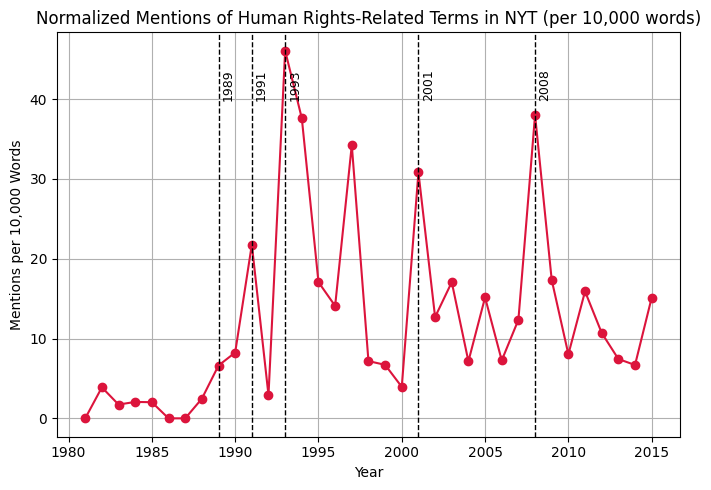

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# 1. Define keywords
human_rights_keywords = [
    'human rights', 'freedom', 'democracy', 'censorship',
    'authoritarian', 'repression', 'protest', 'protests',
    'political prisoner', 'political prisoners'
]

# 2. Count keyword occurrences and total word count per article
def count_keywords(text, keywords):
    text = text.lower()
    return sum(len(re.findall(r'\b' + re.escape(kw.lower()) + r'\b', text)) for kw in keywords)

def count_words(text):
    return len(text.split())

df_nyt_china['keyword_count'] = df_nyt_china['cleaned_content'].apply(lambda x: count_keywords(x, human_rights_keywords))
df_nyt_china['word_count'] = df_nyt_china['cleaned_content'].apply(count_words)

# 3. Group by year and sum keyword and word counts
yearly_stats = df_nyt_china.groupby('year').agg({
    'keyword_count': 'sum',
    'word_count': 'sum'
}).reset_index()

# 4. Normalize
yearly_stats['mentions_per_10k_words'] = (yearly_stats['keyword_count'] / yearly_stats['word_count']) * 10000
yearly_stats = yearly_stats[yearly_stats.year != 1980]

# 5. Plot
plt.figure(figsize=(7, 5))
plt.plot(yearly_stats['year'], yearly_stats['mentions_per_10k_words'], marker='o', color='crimson')
plt.title('Normalized Mentions of Human Rights-Related Terms in NYT (per 10,000 words)')
plt.xlabel('Year')
plt.ylabel('Mentions per 10,000 Words')
plt.grid(True)

highlight_years = [1989, 1991, 1993, 2001, 2008]
for year in highlight_years:
    plt.axvline(x=year, color='black', linestyle='--', linewidth=1)
    plt.text(year + 0.2, max(yearly_stats['mentions_per_10k_words']) * 0.95,
             str(year), rotation=90, color='black', fontsize=9, verticalalignment='top')
             
plt.tight_layout()
plt.show()


In [ ]:
# Extracting topics: NYT-China bin # 1984
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

df_slice = df_nyt_china[df_nyt_china.time_bin == '1']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [30]:
    model_nyt_china = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_china.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_china, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.013*"south" + 0.013*"china" + 0.012*"korea" + 0.011*"korean" + 0.010*"north" + 0.010*"chinese" + 0.009*"geoduck" + 0.009*"ski" + 0.008*"soviet" + 0.007*"official" + 0.006*"said" + 0.005*"would" + 0.005*"year" + 0.004*"last" + 0.004*"skiing" + 0.004*"union" + 0.004*"visit" + 0.004*"one" + 0.004*"country" + 0.004*"two" + 0.004*"diplomat" + 0.003*"government" + 0.003*"first" + 0.003*"peking" + 0.003*"clam" + 0.003*"area" + 0.003*"foreign" + 0.003*"new" + 0.003*"japanese" + 0.003*"may"
Topic 1: 0.014*"stamp" + 0.013*"new" + 0.011*"postal" + 0.011*"envelope" + 0.010*"china" + 0.008*"cent" + 0.007*"clipper" + 0.007*"airmail" + 0.007*"card" + 0.007*"hong" + 0.006*"bison" + 0.006*"first" + 0.006*"service" + 0.005*"transpacific" + 0.005*"territory" + 0.005*"soviet" + 0.005*"american" + 0.005*"kong" + 0.005*"year" + 0.005*"day" + 0.005*"order" + 0.005*"customer" + 0.004*"issued" + 0.004*"march" + 0.004*"san" + 0.004*"calif" + 0.004*"moscow" + 0.004*"postmaster" + 

In [32]:
# Extracting topics: NYT-China bin # 1988
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

df_slice = df_nyt_china[df_nyt_china.time_bin == '2']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [30]:
    model_nyt_china = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_china.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_china, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.021*"bush" + 0.011*"gavin" + 0.010*"said" + 0.009*"president" + 0.007*"boxer" + 0.007*"trip" + 0.006*"hour" + 0.006*"staff" + 0.006*"gym" + 0.006*"shijie" + 0.006*"year" + 0.005*"right" + 0.005*"chinese" + 0.005*"member" + 0.005*"like" + 0.005*"several" + 0.005*"china" + 0.005*"gleasons" + 0.005*"theyre" + 0.004*"four" + 0.004*"even" + 0.004*"last" + 0.004*"hotel" + 0.004*"country" + 0.004*"washington" + 0.004*"instruction" + 0.004*"trainer" + 0.004*"amateur" + 0.004*"boxing" + 0.003*"medal"
Topic 1: 0.012*"market" + 0.011*"said" + 0.010*"price" + 0.009*"percent" + 0.009*"stock" + 0.008*"company" + 0.007*"oil" + 0.006*"year" + 0.005*"bank" + 0.005*"quarter" + 0.005*"last" + 0.005*"energy" + 0.005*"share" + 0.005*"china" + 0.004*"land" + 0.004*"first" + 0.004*"new" + 0.004*"investor" + 0.004*"index" + 0.004*"also" + 0.004*"asian" + 0.004*"economic" + 0.004*"british" + 0.004*"one" + 0.003*"time" + 0.003*"south" + 0.003*"interest" + 0.003*"gain" + 0.003*"ec

In [33]:
# Extracting topics: NYT-China bin # 1992
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

df_slice = df_nyt_china[df_nyt_china.time_bin == '3']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [30]:
    model_nyt_china = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_china.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_china, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.018*"south" + 0.018*"korea" + 0.018*"china" + 0.015*"korean" + 0.010*"game" + 0.009*"north" + 0.008*"year" + 0.006*"beijing" + 0.006*"said" + 0.006*"two" + 0.005*"country" + 0.005*"trade" + 0.005*"chinese" + 0.004*"world" + 0.004*"team" + 0.004*"one" + 0.004*"passenger" + 0.004*"nation" + 0.003*"joint" + 0.003*"air" + 0.003*"foreign" + 0.003*"government" + 0.003*"relation" + 0.003*"medal" + 0.003*"gold" + 0.003*"asian" + 0.003*"soviet" + 0.003*"war" + 0.003*"last" + 0.003*"way"
Topic 1: 0.010*"china" + 0.008*"said" + 0.007*"new" + 0.006*"people" + 0.006*"president" + 0.006*"game" + 0.005*"beijing" + 0.005*"official" + 0.005*"candidate" + 0.004*"party" + 0.004*"chinese" + 0.004*"country" + 0.004*"today" + 0.003*"bush" + 0.003*"would" + 0.003*"government" + 0.003*"clinton" + 0.003*"may" + 0.003*"asian" + 0.003*"also" + 0.003*"year" + 0.003*"city" + 0.003*"sport" + 0.003*"economic" + 0.003*"congress" + 0.003*"jiang" + 0.003*"international" + 0.002*"deng" + 

In [29]:
# Extracting topics: NYT-China bin # 1996
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

df_slice = df_nyt_china[df_nyt_china.time_bin == '4']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [20, 40]:
    model_nyt_china = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_china.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_china, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.015*"china" + 0.013*"said" + 0.012*"chinese" + 0.008*"year" + 0.006*"medal" + 0.006*"world" + 0.006*"olympic" + 0.006*"wei" + 0.005*"one" + 0.005*"state" + 0.005*"last" + 0.005*"game" + 0.005*"team" + 0.005*"first" + 0.004*"united" + 0.004*"gold" + 0.004*"time" + 0.004*"american" + 0.004*"would" + 0.004*"olympics" + 0.003*"beijing" + 0.003*"two" + 0.003*"international" + 0.003*"national" + 0.003*"sport" + 0.003*"player" + 0.003*"people" + 0.003*"second" + 0.003*"like" + 0.003*"coach"
Topic 1: 0.019*"china" + 0.012*"chinese" + 0.011*"right" + 0.011*"wei" + 0.010*"said" + 0.009*"human" + 0.008*"state" + 0.007*"beijing" + 0.007*"official" + 0.007*"clinton" + 0.007*"president" + 0.006*"year" + 0.006*"new" + 0.005*"would" + 0.005*"united" + 0.005*"leader" + 0.004*"political" + 0.004*"dissident" + 0.004*"last" + 0.004*"government" + 0.004*"trade" + 0.004*"democracy" + 0.004*"country" + 0.004*"american" + 0.003*"visit" + 0.003*"security" + 0.003*"prison" + 0.00

In [30]:
# Extracting topics: NYT-China bin # 2000
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

df_slice = df_nyt_china[df_nyt_china.time_bin == '5']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [20, 40]:
    model_nyt_china = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_china.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_china, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.015*"said" + 0.006*"chinese" + 0.006*"new" + 0.006*"year" + 0.005*"china" + 0.004*"team" + 0.004*"time" + 0.004*"world" + 0.003*"drug" + 0.003*"last" + 0.003*"race" + 0.003*"sport" + 0.003*"york" + 0.003*"boat" + 0.003*"people" + 0.003*"would" + 0.003*"state" + 0.003*"government" + 0.003*"day" + 0.003*"like" + 0.003*"one" + 0.003*"official" + 0.003*"first" + 0.003*"olympics" + 0.003*"city" + 0.003*"coach" + 0.002*"school" + 0.002*"two" + 0.002*"dragon" + 0.002*"thompson"
Topic 1: 0.005*"oil" + 0.005*"would" + 0.004*"like" + 0.004*"world" + 0.004*"food" + 0.004*"minute" + 0.004*"game" + 0.004*"australian" + 0.004*"china" + 0.004*"drug" + 0.003*"australia" + 0.003*"time" + 0.003*"add" + 0.003*"one" + 0.003*"tablespoon" + 0.003*"athlete" + 0.003*"sauce" + 0.003*"war" + 0.003*"asian" + 0.003*"make" + 0.003*"new" + 0.003*"two" + 0.002*"cup" + 0.002*"restaurant" + 0.002*"sport" + 0.002*"cooking" + 0.002*"people" + 0.002*"well" + 0.002*"country" + 0.002*"thats"

In [31]:
# Extracting topics: NYT-China bin # 2004
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

df_slice = df_nyt_china[df_nyt_china.time_bin == '6']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [20, 40]:
    model_nyt_china = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_china.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_china, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.025*"china" + 0.010*"said" + 0.010*"chinese" + 0.006*"one" + 0.006*"company" + 0.005*"year" + 0.005*"sport" + 0.005*"right" + 0.005*"state" + 0.004*"also" + 0.004*"beijing" + 0.004*"new" + 0.004*"country" + 0.004*"united" + 0.004*"international" + 0.004*"government" + 0.003*"medium" + 0.003*"like" + 0.003*"many" + 0.003*"race" + 0.003*"time" + 0.003*"television" + 0.003*"world" + 0.003*"formula" + 0.003*"space" + 0.003*"official" + 0.003*"much" + 0.003*"olympics" + 0.003*"even" + 0.003*"million"
Topic 1: 0.017*"chinese" + 0.015*"china" + 0.014*"medal" + 0.010*"olympic" + 0.010*"sport" + 0.009*"game" + 0.009*"team" + 0.009*"said" + 0.008*"olympics" + 0.008*"gold" + 0.007*"world" + 0.007*"year" + 0.007*"athens" + 0.006*"one" + 0.006*"athlete" + 0.006*"first" + 0.005*"badminton" + 0.005*"basketball" + 0.005*"international" + 0.004*"country" + 0.004*"event" + 0.004*"womens" + 0.004*"like" + 0.004*"television" + 0.004*"united" + 0.004*"player" + 0.004*"time" 

In [32]:
# Extracting topics: NYT-China bin # 2008
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

df_slice = df_nyt_china[df_nyt_china.time_bin == '7']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [20, 40]:
    model_nyt_china = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_china.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_china, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.014*"site" + 0.014*"said" + 0.011*"china" + 0.009*"web" + 0.008*"stone" + 0.008*"internet" + 0.005*"dior" + 0.005*"first" + 0.005*"lang" + 0.004*"def" + 0.004*"chinese" + 0.004*"people" + 0.004*"like" + 0.003*"many" + 0.003*"game" + 0.003*"access" + 0.003*"restriction" + 0.003*"time" + 0.003*"great" + 0.003*"round" + 0.003*"tournament" + 0.003*"open" + 0.002*"new" + 0.002*"censorship" + 0.002*"may" + 0.002*"blocked" + 0.002*"know" + 0.002*"second" + 0.002*"lee" + 0.002*"even"
Topic 1: 0.018*"china" + 0.014*"said" + 0.014*"chinese" + 0.009*"right" + 0.009*"torch" + 0.008*"beijing" + 0.007*"human" + 0.006*"government" + 0.006*"people" + 0.006*"protest" + 0.006*"police" + 0.006*"olympic" + 0.005*"official" + 0.005*"security" + 0.004*"one" + 0.004*"group" + 0.004*"olympics" + 0.004*"tibet" + 0.004*"tibetan" + 0.004*"relay" + 0.004*"year" + 0.004*"state" + 0.004*"also" + 0.004*"would" + 0.004*"president" + 0.004*"party" + 0.003*"political" + 0.003*"country" +

In [33]:
# Extracting topics: NYT-China bin # 2012
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

df_slice = df_nyt_china[df_nyt_china.time_bin == '8']

texts = df_slice['lemmas']

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


for num_topic in [20, 40]:
    model_nyt_china = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_nyt_china.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_nyt_china, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.012*"said" + 0.010*"china" + 0.008*"chinese" + 0.006*"one" + 0.005*"beijing" + 0.004*"year" + 0.004*"time" + 0.003*"people" + 0.003*"new" + 0.003*"also" + 0.003*"government" + 0.003*"official" + 0.003*"would" + 0.003*"like" + 0.003*"zhang" + 0.003*"first" + 0.003*"image" + 0.003*"even" + 0.002*"made" + 0.002*"many" + 0.002*"party" + 0.002*"war" + 0.002*"tiger" + 0.002*"last" + 0.002*"state" + 0.002*"box" + 0.002*"game" + 0.002*"trush" + 0.002*"olympics" + 0.002*"say"
Topic 1: 0.011*"said" + 0.010*"china" + 0.007*"player" + 0.006*"year" + 0.006*"first" + 0.006*"chinese" + 0.005*"world" + 0.005*"tennis" + 0.005*"one" + 0.005*"sport" + 0.005*"game" + 0.004*"time" + 0.004*"like" + 0.004*"womens" + 0.004*"match" + 0.004*"woman" + 0.003*"final" + 0.003*"set" + 0.003*"last" + 0.003*"second" + 0.003*"team" + 0.003*"gold" + 0.003*"win" + 0.003*"two" + 0.003*"people" + 0.003*"coach" + 0.002*"japan" + 0.002*"beijing" + 0.002*"top" + 0.002*"new"
Topic 2: 0.011*"said

### People's Daily Central

In [48]:
df_pd = pd.read_csv("peoples_daily_olympics.tsv", delimiter='\t')

In [49]:
import jieba

def segment_text(text):
    segmented_text = ' '.join(jieba.cut(text))
    cleaned_text = re.sub(
        r'[^\u4e00-\u9fff\s]',  # only keep Chinese chars and spaces
        '', 
        segmented_text
    )
    return cleaned_text
    
df_pd['segmented'] = df_pd['content'].apply(segment_text)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/jieba.cache
Loading model cost 1.041 seconds.
Prefix dict has been built successfully.


In [50]:
with open('cn_stopwords.txt', encoding='utf-8') as f:
    stopwords = set(line.strip() for line in f)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

df_pd['filtered'] = df_pd['segmented'].apply(remove_stopwords)


In [51]:
china_keywords_pd = ["中国", "中国队", "中华", "中国人", "我国", "祖国", "国家队", "中国国家队"]
us_keywords_pd = ["美", "美国", "美方", "美国队", "美队", "美国人", "美方代表", "美利坚", "美国国家队"]

In [52]:
def count_mentions(text, keywords):
    return sum(text.split().count(word) for word in keywords)
    
df_pd['china_mentions'] = df_pd['filtered'].apply(lambda x: count_mentions(x, china_keywords_pd))
df_pd['us_mentions'] = df_pd['filtered'].apply(lambda x: count_mentions(x, us_keywords_pd))

In [53]:
def assign_bin_refined(row, threshold=2):
    us_mentions = row['us_mentions']
    china_mentions = row['china_mentions']
    
    if us_mentions <= threshold and china_mentions <= threshold:
        return "Neither"
    
    # Only one country above threshold
    if us_mentions > threshold and china_mentions <= threshold:
        return "US"
    if china_mentions > threshold and us_mentions <= threshold:
        return "China"
    
    # Both above threshold → pick the dominant one
    if us_mentions > china_mentions:
        return "US"
    elif china_mentions > us_mentions:
        return "China"
    else:
        return "Tie"  # Optional: Handle ties separately if you want

In [54]:

df_pd['bin'] = df_pd.apply(assign_bin_refined, axis=1)


In [55]:
df_pd_us = df_pd[df_pd.bin == 'US']
df_pd_china = df_pd[df_pd.bin == 'China']

In [56]:
print(len(df_pd_us))
print(len(df_pd_china))

1172
16246


In [58]:
df_pd_us.columns

Index(['title', 'author', 'date', 'column', 'file_name', 'content',
       'segmented', 'filtered', 'china_mentions', 'us_mentions', 'bin'],
      dtype='object')

In [67]:
# Searchzone for any particular article of interest

df_pd_search = df_pd_us[df_pd_us['content'].str.contains('兴奋剂', case=False, na=False)]

In [71]:
df_pd_search_extract = df_pd_search[df_pd_search.year == 2013]

In [72]:
df_pd_search_extract.iloc[1].content

'薛原人们心目中的英雄被揭开截然相反的面孔，其实也是将人性中最隐秘、最纠结的那部分暴露在阳光下。“伟大”如阿姆斯特朗者，最终击倒他的正是他自己。而当一个人所要面对的最强对手是他自己，是人性本身，这也许是一场没有终点的较量。体坛反兴奋剂斗争如此，人生亦如此阿姆斯特朗终于选择了坦白。面对美国反兴奋剂机构长达千页的调查报告，数名前队友的指证，他曾决意矢口否认——其“顽强”犹如在漫长赛道上的苦苦坚持。但面对如山铁证，“铁人”也有撑不住的时候。最终，阿姆斯特朗选择在美国知名的访谈节目中向主持人奥普拉说出自己的做法和想法。“环法七冠王”的头衔被剥夺，昔日的美国英雄、全民偶像被贴上了欺世盗名的标签。面对如此颠覆性的事实，除了惊愕、愤怒、感叹，还会有什么？过往的光环越是耀眼，如今对自行车运动的打击，对顶尖选手体育精神的怀疑就越是强烈。阿姆斯特朗个人命运的转折，显露出职业体育“双刃剑”的锋利与残酷。在国际体坛，自行车是高度职业化的项目，“百年环法”声名显赫。面对风靡全球的职业体育，曾恪守“业余原则”的奥运会也不得不松开闸门，应时而变。但在巨大的荣誉与利益面前，能否守住体育价值观的基本准则——公平与诚实，阿姆斯特朗的反例，说明“最基本”的也是最困难的。事实面前，人人都可痛斥阿姆斯特朗。但即便如此，他的面孔依然“黑白模糊”。没错，他欺骗了世人。同时，他创立的“坚强生活”抗癌基金会也一直在帮助那些罹患癌症的人们，15年间募款超过4.79亿美元，是所有体育明星基金会之最。过去，阿姆斯特朗的社交媒体签名是“5个孩子的父亲，7届环法自行车赛冠军，全职抗癌专家，兼职铁人三项运动员。”东窗事发之后改为“养育5个孩子。对抗癌症，游泳，自行车，跑步，高尔夫球以及一切我能做的事情。”很难说这纯是虚伪造作，更像一个人被黑白两面缠绕。他的善举不能开脱恶名，他说出真相后，能否获得公众一定程度的原谅是一方面；另一方面，在感慨天网恢恢之时，也该直视这绝非个例，无论现在未来。人们心目中的英雄被揭开截然相反的面孔，其实也是将人性中最隐秘、最纠结的那部分暴露在阳光下。“伟大”如阿姆斯特朗者，最终击倒他的正是他自己。而当一个人所要面对的最强对手是他自己，是人性本身，这也许是一场没有终点的较量。体坛反兴奋剂斗争如此，人生亦如此。'

In [ ]:
# Extracting topics: PD-China bin, whole
from gensim import corpora
from gensim.models import LdaModel

texts = [doc.split() for doc in df_pd_china['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [20, 30, 40, 50, 60]:
    model_pd_30_china = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_china.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_china, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.041*"合作" + 0.037*"中国" + 0.027*"发展" + 0.015*"中" + 0.015*"双方" + 0.013*"关系" + 0.011*"领域" + 0.011*"交流" + 0.010*"经济" + 0.010*"国" + 0.010*"主席" + 0.009*"两" + 0.008*"两国" + 0.008*"共同" + 0.008*"表示" + 0.008*"国际" + 0.008*"国家" + 0.007*"推动" + 0.007*"重要" + 0.007*"加强" + 0.007*"领导人" + 0.007*"总理" + 0.006*"举行" + 0.006*"和平" + 0.006*"巴西" + 0.006*"友好" + 0.005*"说" + 0.005*"总统" + 0.005*"问题" + 0.005*"促进"
Topic 1: 0.145*"韩国" + 0.067*"乒乓球" + 0.047*"韩" + 0.024*"世乒赛" + 0.018*"科普" + 0.014*"中国乒乓球队" + 0.012*"国际乒联" + 0.011*"邮票" + 0.010*"教练组" + 0.009*"墨西哥" + 0.008*"蔡振华" + 0.008*"乒坛" + 0.007*"牵头" + 0.007*"瑞典" + 0.007*"最长" + 0.006*"搭档" + 0.006*"单打" + 0.006*"汉城" + 0.005*"三星" + 0.005*"卢" + 0.005*"周建安" + 0.005*"电气" + 0.004*"沙特队" + 0.004*"乒协" + 0.004*"大阪" + 0.004*"常昊" + 0.004*"施" + 0.004*"必" + 0.004*"乒乓球赛" + 0.004*"全国五一劳动奖章"
Topic 2: 0.034*"残疾人" + 0.026*"活动" + 0.025*"服务" + 0.021*"社会" + 0.019*"教育" + 0.015*"开展" + 0.014*"学生" + 0.014*"西藏" + 0.013*"全国" + 0.013*"组织" + 0.013*"工作" + 0.012*"学校" + 0.009

In [73]:

print("Top words per topic:")
for i, topic in model_pd_30_whole.print_topics(num_words=30, num_topics=30):
    print(f"Topic {i}: {topic}")


Top words per topic:
Topic 0: 0.054*"合作" + 0.031*"发展" + 0.020*"双方" + 0.019*"中" + 0.017*"中国" + 0.017*"关系" + 0.015*"领域" + 0.013*"国" + 0.013*"交流" + 0.012*"两" + 0.012*"两国" + 0.011*"主席" + 0.010*"加强" + 0.010*"共同" + 0.010*"经济" + 0.009*"推动" + 0.009*"表示" + 0.009*"重要" + 0.009*"总理" + 0.008*"国际" + 0.008*"问题" + 0.008*"领导人" + 0.007*"和平" + 0.007*"总统" + 0.007*"友好" + 0.007*"国家" + 0.007*"访问" + 0.006*"进一步" + 0.006*"促进" + 0.006*"取得"
Topic 1: 0.120*"女排" + 0.107*"中国女排" + 0.082*"排球" + 0.030*"郎平" + 0.018*"古巴" + 0.017*"教练组" + 0.015*"墨西哥" + 0.015*"牵头" + 0.009*"阿根廷" + 0.009*"排球队" + 0.008*"卢" + 0.008*"电气" + 0.008*"排协" + 0.008*"带头人" + 0.007*"经济运行" + 0.006*"必" + 0.006*"国际排联" + 0.006*"全国五一劳动奖章" + 0.006*"马拉多纳" + 0.006*"义不容辞" + 0.006*"排坛" + 0.005*"管理人员" + 0.005*"多米尼加" + 0.005*"加勒比" + 0.004*"全面推行" + 0.004*"塞浦路斯" + 0.004*"排球赛" + 0.004*"男排" + 0.003*"雄狮" + 0.003*"雾"
Topic 2: 0.044*"残疾人" + 0.042*"社会" + 0.035*"服务" + 0.035*"活动" + 0.018*"组织" + 0.017*"道德" + 0.017*"开展" + 0.013*"事业" + 0.013*"参与" + 0.012*"文明" + 0.011*"生活" + 0.010

In [19]:
# Extracting topics: PD-US bin, whole
from gensim import corpora
from gensim.models import LdaModel

texts = [doc.split() for doc in df_pd_us['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [20, 30, 40, 50, 60]:
    model_pd_30_us = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_us.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_us, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.020*"美国" + 0.017*"中国" + 0.013*"中" + 0.013*"美" + 0.012*"合作" + 0.011*"发展" + 0.009*"问题" + 0.007*"双方" + 0.006*"关系" + 0.006*"交流" + 0.005*"表示" + 0.005*"经济" + 0.005*"中美关系" + 0.005*"国际" + 0.005*"北京" + 0.005*"说" + 0.005*"中美" + 0.004*"两国" + 0.004*"重要" + 0.004*"总统" + 0.004*"战略" + 0.004*"世界" + 0.004*"中方" + 0.004*"共同" + 0.004*"对话" + 0.003*"美方" + 0.003*"国" + 0.003*"记者" + 0.003*"主席" + 0.003*"国家"
Topic 1: 0.011*"体育" + 0.010*"美国" + 0.010*"运动员" + 0.005*"奥运会" + 0.005*"中" + 0.004*"参加" + 0.004*"训练" + 0.004*"说" + 0.004*"比赛" + 0.004*"选手" + 0.003*"布兰达" + 0.003*"参赛" + 0.003*"全运会" + 0.003*"中国" + 0.003*"北京" + 0.003*"记者" + 0.003*"岁" + 0.003*"游泳" + 0.003*"没有" + 0.003*"进行" + 0.003*"美国队" + 0.002*"大学" + 0.002*"一个" + 0.002*"中医" + 0.002*"项目" + 0.002*"体协" + 0.002*"代表团" + 0.002*"金牌" + 0.002*"更" + 0.002*"会"
Topic 2: 0.018*"美国" + 0.007*"国家" + 0.007*"说" + 0.005*"一个" + 0.005*"和平" + 0.004*"中" + 0.004*"人民" + 0.004*"国际" + 0.004*"进行" + 0.003*"认为" + 0.003*"世界" + 0.003*"这种" + 0.003*"没有" + 0.003*"问题"

In [75]:
print("Top words per topic:")
for i, topic in model_pd_30_whole_us.print_topics(num_words=30, num_topics=30):
    print(f"Topic {i}: {topic}")

Top words per topic:
Topic 0: 0.017*"美国" + 0.017*"中国" + 0.014*"中" + 0.013*"发展" + 0.012*"美" + 0.011*"合作" + 0.010*"问题" + 0.008*"双方" + 0.007*"关系" + 0.006*"中美关系" + 0.006*"表示" + 0.006*"经济" + 0.006*"北京" + 0.006*"说" + 0.005*"重要" + 0.005*"两国" + 0.005*"中美" + 0.005*"国际" + 0.004*"世界" + 0.004*"希望" + 0.004*"总统" + 0.004*"对话" + 0.004*"记者" + 0.004*"战略" + 0.004*"美方" + 0.004*"国" + 0.004*"主席" + 0.004*"中方" + 0.004*"稳定" + 0.004*"两"
Topic 1: 0.015*"体育" + 0.011*"美国" + 0.009*"运动员" + 0.007*"奥运会" + 0.006*"选手" + 0.006*"中" + 0.006*"训练" + 0.006*"参加" + 0.005*"说" + 0.005*"比赛" + 0.004*"中国" + 0.004*"布兰达" + 0.004*"全运会" + 0.004*"项目" + 0.004*"田径" + 0.004*"兴奋剂" + 0.004*"记者" + 0.004*"游泳" + 0.003*"美国队" + 0.003*"体协" + 0.003*"没有" + 0.003*"教练" + 0.003*"会" + 0.003*"参赛" + 0.003*"金牌" + 0.003*"大学" + 0.003*"名" + 0.003*"大学生" + 0.002*"公斤" + 0.002*"枚"
Topic 2: 0.016*"美国" + 0.005*"国际" + 0.005*"中国" + 0.005*"说" + 0.005*"女足" + 0.004*"中" + 0.004*"奥运会" + 0.004*"一个" + 0.003*"进行" + 0.003*"中国女足" + 0.003*"奥运" + 0.003*"华人" + 0.003*"国家" + 0.003*"

In [62]:
# Convert string date to datetime if not already
df_pd_china['date'] = pd.to_datetime(df_pd_china['date'])

df_pd_china['year'] = df_pd_china['date'].dt.year

df_pd_us['date'] = pd.to_datetime(df_pd_us['date'])

df_pd_us['year'] = df_pd_us['date'].dt.year

def assign_time_bin_pd(year):
    if year < 1982:
        return '0'
    elif 1982 <= year <= 1985:
        return '1'
    elif 1986 <= year <= 1989:
        return '2'
    elif 1990 <= year <= 1993:
        return '3'
    elif 1994 <= year <= 1997:
        return '4'
    elif 1998 <= year <= 2001:
        return '5'
    elif 2002 <= year <= 2005:
        return '6'
    elif 2006 <= year <= 2009:
        return '7'
    elif 2010 <= year <= 2013:
        return '8'
    else:
        return 'Post-2013 or N/A'

df_pd_china['time_bin'] = df_pd_china['year'].apply(assign_time_bin_pd)
df_pd_us['time_bin'] = df_pd_us['year'].apply(assign_time_bin_pd)

/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_1826/3514733708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd_china['date'] = pd.to_datetime(df_pd_china['date'])
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_1826/3514733708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd_china['year'] = df_pd_china['date'].dt.year
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_1826/3514733708.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

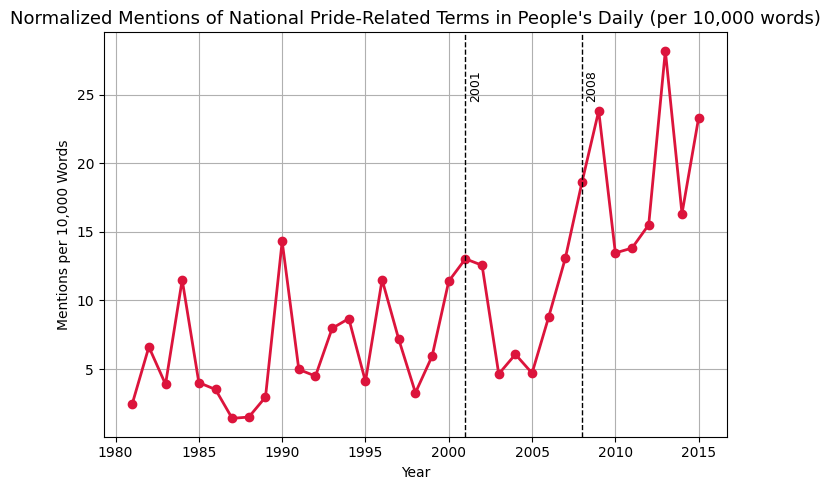

In [98]:
# PD on China nationalism national pride

import pandas as pd
import matplotlib.pyplot as plt
import re

# Define keywords
national_pride_keywords = [
    '爱国', '复兴', '中华民族', '民族精神', '振兴', '伟大'
]

# Keyword and word count functions
def count_keywords(text, keywords):
    text = text.lower()
    return sum(len(re.findall(r'\b' + re.escape(kw.lower()) + r'\b', text)) for kw in keywords)

def count_words(text):
    return len(text.split())

# Apply counts to dataframe
df_pd_china['keyword_count'] = df_pd_china['filtered'].apply(lambda x: count_keywords(x, national_pride_keywords))
df_pd_china['word_count'] = df_pd_china['filtered'].apply(count_words)

# Group and normalize
yearly_stats = df_pd_china.groupby('year').agg({
    'keyword_count': 'sum',
    'word_count': 'sum'
}).reset_index()

yearly_stats = yearly_stats[yearly_stats.year >= 1981]

yearly_stats['mentions_per_10k_words'] = (yearly_stats['keyword_count'] / yearly_stats['word_count']) * 10000

# Plot
plt.figure(figsize=(7, 5))
plt.plot(yearly_stats['year'], yearly_stats['mentions_per_10k_words'], marker='o', color='crimson', linewidth=2)
plt.title("Normalized Mentions of National Pride-Related Terms in People's Daily (per 10,000 words)", fontsize=13)
plt.xlabel('Year')
plt.ylabel('Mentions per 10,000 Words')
plt.grid(True)

# Add vertical dashed lines and annotations
highlight_years = [2001, 2008]
for year in highlight_years:
    plt.axvline(x=year, color='black', linestyle='--', linewidth=1)
    plt.text(year + 0.2, max(yearly_stats['mentions_per_10k_words']) * 0.95,
             str(year), rotation=90, color='black', fontsize=9, verticalalignment='top')

plt.tight_layout()
plt.show()


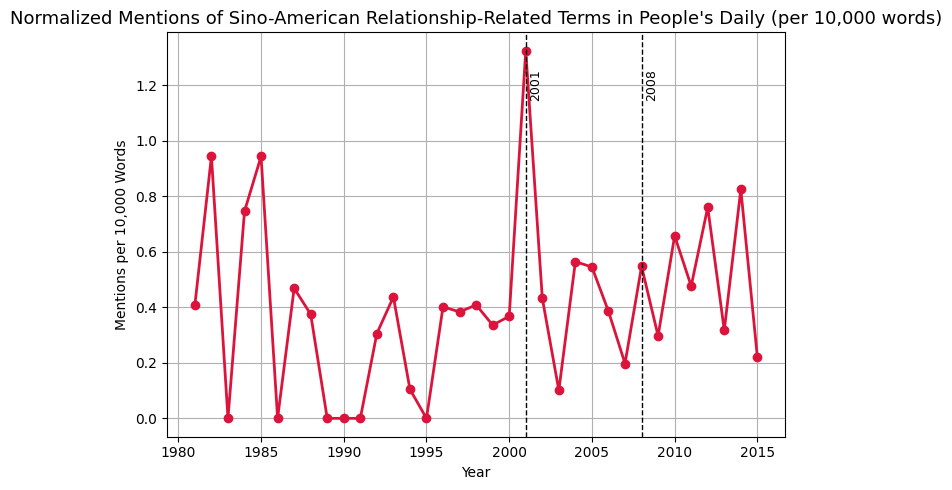

In [100]:
# PD on US US-China relationships

import pandas as pd
import matplotlib.pyplot as plt
import re

# Define keywords
us_china_relations_keywords = [
    "中美", "中美关系"
]

# Keyword and word count functions
def count_keywords(text, keywords):
    text = text.lower()
    return sum(len(re.findall(r'\b' + re.escape(kw.lower()) + r'\b', text)) for kw in keywords)

def count_words(text):
    return len(text.split())

# Apply counts to dataframe
df_pd_china['keyword_count'] = df_pd_china['filtered'].apply(lambda x: count_keywords(x, us_china_relations_keywords))
df_pd_china['word_count'] = df_pd_china['filtered'].apply(count_words)

# Group and normalize
yearly_stats = df_pd_china.groupby('year').agg({
    'keyword_count': 'sum',
    'word_count': 'sum'
}).reset_index()

yearly_stats = yearly_stats[yearly_stats.year >= 1981]

yearly_stats['mentions_per_10k_words'] = (yearly_stats['keyword_count'] / yearly_stats['word_count']) * 10000

# Plot
plt.figure(figsize=(7, 5))
plt.plot(yearly_stats['year'], yearly_stats['mentions_per_10k_words'], marker='o', color='crimson', linewidth=2)
plt.title("Normalized Mentions of Sino-American Relationship-Related Terms in People's Daily (per 10,000 words)", fontsize=13)
plt.xlabel('Year')
plt.ylabel('Mentions per 10,000 Words')
plt.grid(True)

# Add vertical dashed lines and annotations
highlight_years = [2001, 2008]
for year in highlight_years:
    plt.axvline(x=year, color='black', linestyle='--', linewidth=1)
    plt.text(year + 0.2, max(yearly_stats['mentions_per_10k_words']) * 0.95,
             str(year), rotation=90, color='black', fontsize=9, verticalalignment='top')

plt.tight_layout()
plt.show()

/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/4000359053.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd_china['socialism_keyword_count'] = df_pd_china['filtered'].apply(lambda x: count_keywords(x, socialism_keywords))
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/4000359053.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd_china['chinese_char_keyword_count'] = df_pd_china['filtered'].apply(lambda x: count_keywords(x, chinese_char_keywords))
/var/fol

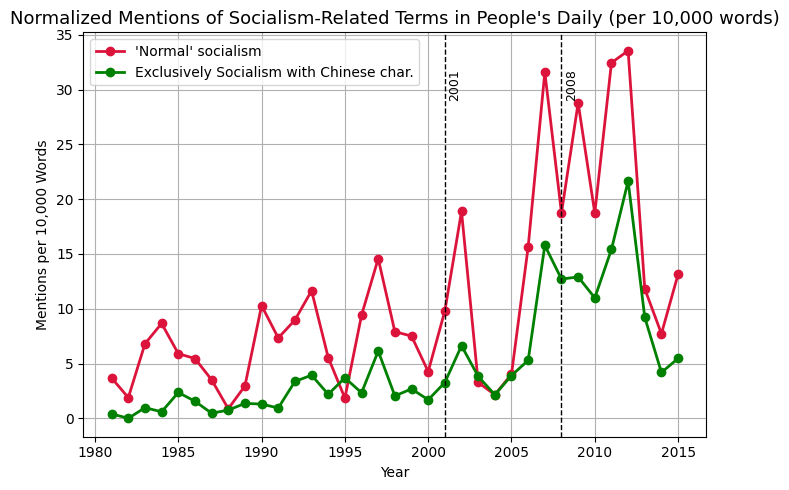

In [83]:
# PD on China Socialism (with Chinese characteristics)

import pandas as pd
import matplotlib.pyplot as plt
import re

# Define keywords
socialism_keywords = [
    "社会主义", "共产主义", "无产阶级"
]

chinese_char_keywords = [
    "中国特色", "特色", "中国特色社会主义"
]

# Keyword and word count functions
def count_keywords(text, keywords):
    text = text.lower()
    return sum(len(re.findall(r'\b' + re.escape(kw.lower()) + r'\b', text)) for kw in keywords)

def count_words(text):
    return len(text.split())

# Apply counts to dataframe
df_pd_china['socialism_keyword_count'] = df_pd_china['filtered'].apply(lambda x: count_keywords(x, socialism_keywords))
df_pd_china['chinese_char_keyword_count'] = df_pd_china['filtered'].apply(lambda x: count_keywords(x, chinese_char_keywords))
df_pd_china['word_count'] = df_pd_china['filtered'].apply(count_words)

# Group and normalize
yearly_stats = df_pd_china.groupby('year').agg({
    'socialism_keyword_count': 'sum',
    'chinese_char_keyword_count': 'sum',
    'word_count': 'sum'
}).reset_index()

yearly_stats = yearly_stats[yearly_stats.year >= 1981]

yearly_stats['socialism_mentions_10k'] = (yearly_stats['socialism_keyword_count'] / yearly_stats['word_count']) * 10000
yearly_stats['chinese_char_mentions_10k'] = (yearly_stats['chinese_char_keyword_count'] / yearly_stats['word_count']) * 10000

# Plot
plt.figure(figsize=(7, 5))
plt.plot(yearly_stats['year'], yearly_stats['socialism_mentions_10k'], marker='o', color='crimson', label="'Normal' socialism", linewidth=2)
plt.plot(yearly_stats['year'], yearly_stats['chinese_char_mentions_10k'], marker='o', color='green', label="Exclusively Socialism with Chinese char.", linewidth=2)
plt.title("Normalized Mentions of Socialism-Related Terms in People's Daily (per 10,000 words)", fontsize=13)
plt.xlabel('Year')
plt.ylabel('Mentions per 10,000 Words')
plt.grid(True)

# Add vertical dashed lines and annotations
highlight_years = [2001, 2008]
for year in highlight_years:
    plt.axvline(x=year, color='black', linestyle='--', linewidth=1)
    plt.text(year + 0.2, max(yearly_stats['socialism_mentions_10k']) * 0.95,
             str(year), rotation=90, color='black', fontsize=9, verticalalignment='top')

plt.legend()
plt.tight_layout()
plt.show()

/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/3546561112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt_us['keyword_count'] = df_nyt_us['cleaned_content'].apply(lambda x: count_keywords(x, drug_keywords))
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/3546561112.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyt_us['word_count'] = df_nyt_us['cleaned_content'].apply(count_words)
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/3546561

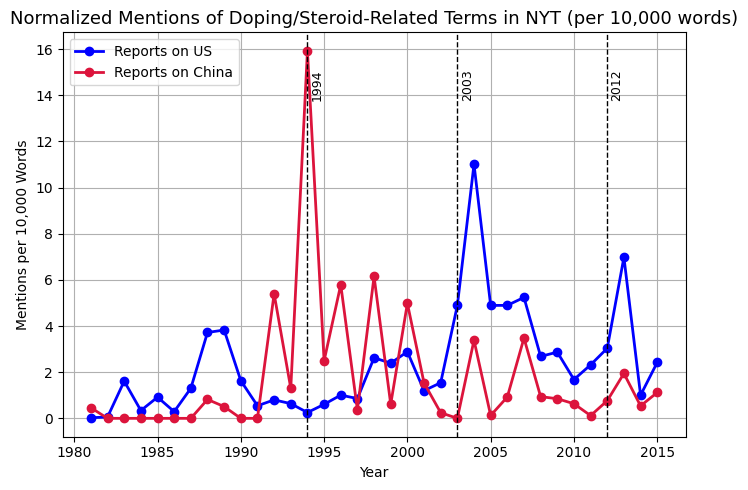

In [85]:
# NYT on US drugs doping steroids
# NYT on Chinese drugs doping steroids

import pandas as pd
import matplotlib.pyplot as plt
import re

# Define keywords
drug_keywords = [
    "doping", "steroids", "performance-enhancing", "drug scandal", "drug testing"
]

# Keyword and word count functions
def count_keywords(text, keywords):
    text = text.lower()
    return sum(len(re.findall(r'\b' + re.escape(kw.lower()) + r'\b', text)) for kw in keywords)

def count_words(text):
    return len(text.split())

# Apply counts to dataframe
df_nyt_us['keyword_count'] = df_nyt_us['cleaned_content'].apply(lambda x: count_keywords(x, drug_keywords))
df_nyt_us['word_count'] = df_nyt_us['cleaned_content'].apply(count_words)
df_nyt_china['keyword_count'] = df_nyt_china['cleaned_content'].apply(lambda x: count_keywords(x, drug_keywords))
df_nyt_china['word_count'] = df_nyt_china['cleaned_content'].apply(count_words)

# Group and normalize
us_yearly_stats = df_nyt_us.groupby('year').agg({
    'keyword_count': 'sum',
    'word_count': 'sum'
}).reset_index()

china_yearly_stats = df_nyt_china.groupby('year').agg({
    'keyword_count': 'sum',
    'word_count': 'sum'
}).reset_index()

us_yearly_stats = us_yearly_stats[us_yearly_stats.year >= 1981]

us_yearly_stats['mentions_per_10k_words'] = (us_yearly_stats['keyword_count'] / us_yearly_stats['word_count']) * 10000

china_yearly_stats = china_yearly_stats[china_yearly_stats.year >= 1981]

china_yearly_stats['mentions_per_10k_words'] = (china_yearly_stats['keyword_count'] / china_yearly_stats['word_count']) * 10000

# Plot
plt.figure(figsize=(7, 5))
plt.plot(us_yearly_stats['year'], us_yearly_stats['mentions_per_10k_words'], marker='o', color='blue', label='Reports on US', linewidth=2)
plt.plot(china_yearly_stats['year'], china_yearly_stats['mentions_per_10k_words'], marker='o', color='crimson', label='Reports on China', linewidth=2)
plt.title("Normalized Mentions of Doping/Steroid-Related Terms in NYT (per 10,000 words)", fontsize=13)
plt.xlabel('Year')
plt.ylabel('Mentions per 10,000 Words')
plt.grid(True)

# Add vertical dashed lines and annotations
highlight_years = [1994, 2003, 2012]
for year in highlight_years:
    plt.axvline(x=year, color='black', linestyle='--', linewidth=1)
    plt.text(year + 0.2, max(china_yearly_stats['mentions_per_10k_words']) * 0.95,
             str(year), rotation=90, color='black', fontsize=9, verticalalignment='top')

plt.legend()
plt.tight_layout()
plt.show()

/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/23869184.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd_us['keyword_count'] = df_pd_us['filtered'].apply(lambda x: count_keywords(x, drug_keywords))
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/23869184.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pd_us['word_count'] = df_pd_us['filtered'].apply(count_words)
/var/folders/n5/5bjjwdbx0llbf97lrz9qczz40000gn/T/ipykernel_64811/23869184.py:23: SettingWithCo

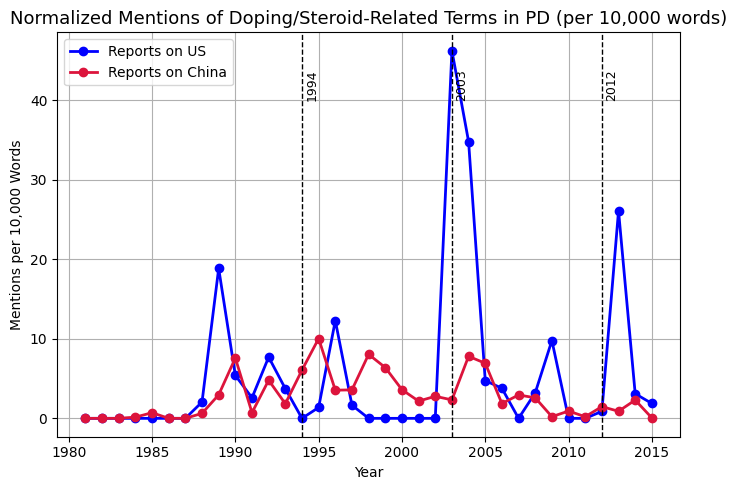

In [87]:
# PD on China nationalism national pride

import pandas as pd
import matplotlib.pyplot as plt
import re

# Define keywords
drug_keywords = [
    "兴奋剂", "禁药", "药检", "服药"
]

# Keyword and word count functions
def count_keywords(text, keywords):
    text = text.lower()
    return sum(len(re.findall(r'\b' + re.escape(kw.lower()) + r'\b', text)) for kw in keywords)

def count_words(text):
    return len(text.split())

# Apply counts to dataframe
df_pd_us['keyword_count'] = df_pd_us['filtered'].apply(lambda x: count_keywords(x, drug_keywords))
df_pd_us['word_count'] = df_pd_us['filtered'].apply(count_words)
df_pd_china['keyword_count'] = df_pd_china['filtered'].apply(lambda x: count_keywords(x, drug_keywords))
df_pd_china['word_count'] = df_pd_china['filtered'].apply(count_words)

# Group and normalize
us_yearly_stats = df_pd_us.groupby('year').agg({
    'keyword_count': 'sum',
    'word_count': 'sum'
}).reset_index()

china_yearly_stats = df_pd_china.groupby('year').agg({
    'keyword_count': 'sum',
    'word_count': 'sum'
}).reset_index()

us_yearly_stats = us_yearly_stats[us_yearly_stats.year >= 1981]

us_yearly_stats['mentions_per_10k_words'] = (us_yearly_stats['keyword_count'] / us_yearly_stats['word_count']) * 10000

china_yearly_stats = china_yearly_stats[china_yearly_stats.year >= 1981]

china_yearly_stats['mentions_per_10k_words'] = (china_yearly_stats['keyword_count'] / china_yearly_stats['word_count']) * 10000

# Plot
plt.figure(figsize=(7, 5))
plt.plot(us_yearly_stats['year'], us_yearly_stats['mentions_per_10k_words'], marker='o', color='blue', label='Reports on US', linewidth=2)
plt.plot(china_yearly_stats['year'], china_yearly_stats['mentions_per_10k_words'], marker='o', color='crimson', label='Reports on China', linewidth=2)
plt.title("Normalized Mentions of Doping/Steroid-Related Terms in PD (per 10,000 words)", fontsize=13)
plt.xlabel('Year')
plt.ylabel('Mentions per 10,000 Words')
plt.grid(True)

# Add vertical dashed lines and annotations
highlight_years = [1994, 2003, 2012]
for year in highlight_years:
    plt.axvline(x=year, color='black', linestyle='--', linewidth=1)
    plt.text(year + 0.2, max(us_yearly_stats['mentions_per_10k_words']) * 0.95,
             str(year), rotation=90, color='black', fontsize=9, verticalalignment='top')

plt.legend()
plt.tight_layout()
plt.show()


In [51]:
# Extracting topics: PD-China bin, up to 1981
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_china[df_pd_china.time_bin == '0']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [20, 30, 40, 50, 60]:
    model_pd_30_china_1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_china_1.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_china_1, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.020*"代表团" + 0.020*"中国" + 0.016*"访问" + 0.015*"副" + 0.014*"北京" + 0.011*"主席" + 0.009*"进行" + 0.009*"驻" + 0.008*"到达" + 0.008*"新华社" + 0.008*"我国" + 0.008*"团长" + 0.007*"友好访问" + 0.007*"机场" + 0.007*"举行" + 0.007*"九月" + 0.007*"部长" + 0.006*"主任" + 0.006*"友好" + 0.006*"委员会" + 0.006*"负责人" + 0.006*"招待会" + 0.006*"离开" + 0.006*"结束" + 0.006*"版" + 0.006*"专栏" + 0.006*"前往" + 0.006*"欢迎" + 0.006*"会见" + 0.005*"乘飞机"
Topic 1: 0.030*"比赛" + 0.023*"锦标赛" + 0.021*"世界" + 0.019*"中" + 0.018*"体操" + 0.014*"分" + 0.012*"获得" + 0.011*"冠军" + 0.011*"选手" + 0.011*"女子" + 0.011*"男子" + 0.010*"成绩" + 0.009*"动作" + 0.009*"参加" + 0.007*"中国" + 0.007*"奥运会" + 0.007*"运动员" + 0.007*"队" + 0.006*"苏联" + 0.006*"亚军" + 0.006*"取得" + 0.005*"中国队" + 0.005*"我国" + 0.005*"日本" + 0.005*"项目" + 0.005*"获" + 0.005*"苏联队" + 0.005*"水平" + 0.004*"上届" + 0.004*"团体"
Topic 2: 0.020*"比赛" + 0.017*"成绩" + 0.013*"中" + 0.013*"运动员" + 0.011*"公尺" + 0.009*"我国" + 0.008*"获得" + 0.008*"队" + 0.006*"秒" + 0.006*"冠军" + 0.006*"苏联" + 0.006*"男子" + 0.006*"女子" + 0.0

In [57]:
# Extracting topics: PD-China bin, 1984
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_china[df_pd_china.time_bin == '1']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topic in [20]:
    model_pd_30_china_2 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_china_2.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_china_2, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.008*"场馆" + 0.007*"中国" + 0.006*"组" + 0.006*"世界" + 0.006*"比赛" + 0.006*"我国" + 0.004*"锦标赛" + 0.004*"冰球" + 0.004*"中" + 0.003*"体育设施" + 0.003*"历史" + 0.003*"花剑" + 0.003*"奥运会" + 0.003*"水平" + 0.003*"没有" + 0.003*"体育场馆" + 0.003*"毛里塔尼亚" + 0.003*"太" + 0.002*"金牌" + 0.002*"方面" + 0.002*"国际" + 0.002*"冰球队" + 0.002*"版" + 0.002*"专栏" + 0.002*"之间" + 0.002*"举行" + 0.002*"建设" + 0.002*"体育界" + 0.002*"国家" + 0.002*"群众"
Topic 1: 0.020*"中国" + 0.012*"运动员" + 0.010*"我国" + 0.009*"中" + 0.007*"比赛" + 0.007*"成绩" + 0.006*"名" + 0.005*"奥运会" + 0.005*"世界" + 0.005*"参加" + 0.004*"水平" + 0.004*"新" + 0.003*"训练" + 0.003*"男子" + 0.003*"运动" + 0.003*"游泳" + 0.003*"人民" + 0.003*"秒" + 0.003*"亚运会" + 0.003*"体育" + 0.003*"专栏" + 0.003*"说" + 0.003*"版" + 0.003*"日本" + 0.003*"发展" + 0.003*"米" + 0.003*"国家" + 0.003*"时" + 0.003*"印度" + 0.003*"提高"
Topic 2: 0.014*"中国" + 0.010*"我国" + 0.008*"游泳" + 0.007*"中" + 0.007*"亚运会" + 0.006*"说" + 0.006*"亚洲" + 0.006*"世界" + 0.006*"奥运会" + 0.006*"运动员" + 0.005*"金牌" + 0.005*"发展" + 0.005*"训练" + 0.00

In [58]:
# Extracting topics: PD-China bin, 1988
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_china[df_pd_china.time_bin == '2']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topic in [20]:
    model_pd_30_china_2 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_china_2.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_china_2, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.016*"中国" + 0.016*"选手" + 0.014*"比赛" + 0.012*"奥运会" + 0.011*"中" + 0.011*"金牌" + 0.010*"女子" + 0.009*"项目" + 0.009*"成绩" + 0.008*"世界" + 0.007*"米" + 0.007*"我国" + 0.007*"体育" + 0.007*"运动员" + 0.006*"男子" + 0.006*"枚" + 0.006*"参加" + 0.006*"分" + 0.005*"冠军" + 0.005*"中国队" + 0.005*"专栏" + 0.005*"版" + 0.005*"体操" + 0.004*"跳水" + 0.004*"获得" + 0.004*"夺得" + 0.004*"锦标赛" + 0.004*"苏联" + 0.004*"记者" + 0.004*"秒"
Topic 1: 0.014*"体育" + 0.013*"中国" + 0.009*"比赛" + 0.008*"奥运会" + 0.008*"亚洲" + 0.007*"说" + 0.007*"世界" + 0.007*"运动员" + 0.007*"中" + 0.007*"我国" + 0.006*"参加" + 0.006*"记者" + 0.006*"选手" + 0.005*"项目" + 0.005*"锦标赛" + 0.004*"水平" + 0.004*"运动" + 0.004*"训练" + 0.004*"亚运会" + 0.004*"教练" + 0.004*"中国队" + 0.004*"专栏" + 0.004*"版" + 0.003*"没有" + 0.003*"金牌" + 0.003*"南朝鲜" + 0.003*"国际" + 0.003*"时" + 0.003*"举行" + 0.003*"队员"
Topic 2: 0.008*"说" + 0.006*"徐曼" + 0.005*"曹群" + 0.004*"中国" + 0.004*"一个" + 0.003*"台胞" + 0.003*"台湾" + 0.003*"发展" + 0.003*"北京" + 0.003*"中" + 0.003*"朋友" + 0.003*"会" + 0.002*"学生" + 0.002*"想" 

In [55]:
# Extracting topics: PD-China bin, 1992
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_china[df_pd_china.time_bin == '3']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topic in [30]:
    model_pd_30_china_2 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_china_2.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_china_2, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.028*"中国" + 0.025*"选手" + 0.019*"冠军" + 0.016*"比赛" + 0.016*"中" + 0.014*"金牌" + 0.014*"女子" + 0.012*"决赛" + 0.012*"奥运会" + 0.011*"今天" + 0.011*"获得" + 0.010*"男子" + 0.010*"分" + 0.009*"获" + 0.009*"记者" + 0.008*"版" + 0.008*"专栏" + 0.007*"日电" + 0.007*"米" + 0.007*"夺得" + 0.007*"中国队" + 0.007*"本报" + 0.006*"枚" + 0.006*"成绩" + 0.006*"名" + 0.006*"进入" + 0.005*"韩国" + 0.005*"要闻" + 0.005*"锦标赛" + 0.005*"新华社"
Topic 1: 0.007*"亚运会" + 0.005*"比赛" + 0.004*"训练" + 0.004*"说" + 0.004*"总理" + 0.004*"配角" + 0.004*"运动员" + 0.004*"伏明霞" + 0.003*"李鹏" + 0.003*"我国" + 0.003*"希望" + 0.003*"中国" + 0.003*"克拉克" + 0.003*"时" + 0.003*"中" + 0.003*"版" + 0.002*"一个" + 0.002*"成绩" + 0.002*"本报记者" + 0.002*"前" + 0.002*"没有" + 0.002*"奥运会" + 0.002*"专栏" + 0.002*"生产" + 0.002*"工人" + 0.002*"正在" + 0.002*"提供" + 0.002*"郢" + 0.002*"器材" + 0.002*"进行"
Topic 2: 0.024*"体育" + 0.008*"中国" + 0.006*"东亚" + 0.005*"我国" + 0.005*"全国" + 0.005*"运动员" + 0.005*"文化" + 0.005*"北京" + 0.004*"发展" + 0.004*"参加" + 0.004*"中" + 0.004*"运动会" + 0.004*"工作" + 0.004*"主

In [56]:
# Extracting topics: PD-China bin, 1996
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_china[df_pd_china.time_bin == '4']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topic in [30]:
    model_pd_30_china_2 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_china_2.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_china_2, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.007*"体育" + 0.006*"员工" + 0.005*"体育产业" + 0.005*"提高" + 0.005*"我国" + 0.004*"发展" + 0.004*"工作" + 0.004*"工人" + 0.004*"技术" + 0.004*"技能" + 0.004*"中" + 0.004*"二厂" + 0.003*"自行车" + 0.003*"基金会" + 0.003*"水平" + 0.003*"周素" + 0.003*"科技" + 0.003*"足球" + 0.002*"教育" + 0.002*"英" + 0.002*"电话" + 0.002*"培养" + 0.002*"更" + 0.002*"人才" + 0.002*"一个" + 0.002*"集团" + 0.002*"中国" + 0.002*"北京" + 0.002*"会" + 0.002*"举办"
Topic 1: 0.012*"体育" + 0.006*"中" + 0.005*"健身" + 0.005*"一个" + 0.005*"全民" + 0.005*"中国" + 0.004*"武钢" + 0.004*"数学" + 0.004*"邮票" + 0.004*"学生" + 0.003*"杨克" + 0.003*"全国" + 0.003*"火炬" + 0.003*"三中" + 0.003*"说" + 0.003*"钱" + 0.003*"展望" + 0.003*"人民" + 0.003*"出" + 0.003*"刘诗雄" + 0.003*"计划" + 0.003*"群众" + 0.003*"朱辰畅" + 0.002*"亚洲" + 0.002*"黄益" + 0.002*"周彤" + 0.002*"我国" + 0.002*"运动" + 0.002*"没有" + 0.002*"发展"
Topic 2: 0.027*"中国" + 0.021*"金牌" + 0.017*"选手" + 0.012*"项目" + 0.011*"比赛" + 0.011*"枚" + 0.010*"女子" + 0.009*"体育" + 0.009*"中" + 0.008*"世界" + 0.008*"成绩" + 0.008*"米" + 0.008*"奥运会" + 0.007*"运动员"

In [57]:
# Extracting topics: PD-China bin, 2000
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_china[df_pd_china.time_bin == '5']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topic in [30]:
    model_pd_30_china_2 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_china_2.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_china_2, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.019*"中国" + 0.010*"发展" + 0.007*"一个" + 0.007*"世界" + 0.006*"建设" + 0.006*"中" + 0.006*"文化" + 0.006*"社会" + 0.006*"活动" + 0.005*"国际" + 0.005*"国家" + 0.005*"文明" + 0.004*"问题" + 0.004*"台湾" + 0.004*"人民" + 0.004*"社会主义" + 0.003*"工作" + 0.003*"提高" + 0.003*"服务" + 0.003*"成为" + 0.003*"爱国主义" + 0.003*"经济" + 0.003*"教育" + 0.003*"我国" + 0.003*"新" + 0.003*"重要" + 0.003*"精神" + 0.003*"社区" + 0.003*"北京" + 0.002*"大会"
Topic 1: 0.016*"国际" + 0.011*"中国" + 0.010*"举行" + 0.008*"主席" + 0.007*"会议" + 0.007*"北京" + 0.007*"武联" + 0.007*"武术" + 0.006*"邓小平" + 0.006*"世界" + 0.006*"招待会" + 0.006*"决定" + 0.006*"体操" + 0.005*"天津" + 0.005*"锦标赛" + 0.005*"代表" + 0.005*"指出" + 0.005*"中共中央" + 0.005*"出席" + 0.004*"讲话" + 0.004*"成立" + 0.004*"音乐节" + 0.004*"中华人民共和国" + 0.004*"香港" + 0.004*"国务院" + 0.004*"提出" + 0.004*"社会主义" + 0.004*"全国政协" + 0.003*"记者" + 0.003*"国家"
Topic 2: 0.009*"赛艇" + 0.008*"中国" + 0.008*"运动" + 0.006*"世界" + 0.006*"体操" + 0.006*"比赛" + 0.005*"北京" + 0.005*"说" + 0.004*"活动" + 0.004*"举办" + 0.004*"国际" + 0.004*"锦标赛" + 0.

In [58]:
# Extracting topics: PD-China bin, 2004
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_china[df_pd_china.time_bin == '6']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topic in [30]:
    model_pd_30_china_2 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_china_2.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_china_2, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.014*"体育" + 0.013*"人民" + 0.010*"中国" + 0.009*"新" + 0.009*"北京" + 0.009*"精神" + 0.009*"我国" + 0.007*"工作" + 0.007*"全国" + 0.006*"祖国" + 0.006*"奥运会" + 0.006*"活动" + 0.005*"建设" + 0.005*"民族" + 0.005*"代表" + 0.005*"主席" + 0.005*"领导" + 0.004*"重要" + 0.004*"中华民族" + 0.004*"社会主义" + 0.004*"中" + 0.004*"同志" + 0.004*"副" + 0.004*"取得" + 0.004*"说" + 0.004*"江泽民" + 0.004*"教育" + 0.004*"发展" + 0.004*"体育事业" + 0.003*"成功"
Topic 1: 0.026*"选手" + 0.018*"中国" + 0.018*"中国队" + 0.017*"比赛" + 0.015*"乒乓球" + 0.014*"中" + 0.014*"冠军" + 0.013*"世乒赛" + 0.013*"男单" + 0.008*"女单" + 0.008*"决赛" + 0.008*"对手" + 0.008*"组合" + 0.008*"男双" + 0.007*"战胜" + 0.007*"混双" + 0.006*"羽毛球" + 0.005*"世界排名" + 0.005*"花样滑冰" + 0.005*"公开赛" + 0.005*"奥运会" + 0.005*"林丹" + 0.005*"张宁" + 0.005*"双打" + 0.005*"马琳" + 0.005*"王楠" + 0.005*"王励勤" + 0.004*"名将" + 0.004*"半决赛" + 0.004*"高"
Topic 2: 0.018*"发展" + 0.013*"建设" + 0.008*"工作" + 0.008*"社会" + 0.007*"经济" + 0.007*"加强" + 0.005*"提高" + 0.005*"国家" + 0.005*"全国" + 0.005*"保护" + 0.005*"我国" + 0.005*"问题" + 0.005*

In [59]:
# Extracting topics: PD-China bin, 2008
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_china[df_pd_china.time_bin == '7']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topic in [30]:
    model_pd_30_china_2 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_china_2.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_china_2, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.039*"网民" + 0.030*"南极" + 0.015*"同济" + 0.011*"三星" + 0.009*"冰盖" + 0.009*"极地" + 0.008*"表示慰问" + 0.006*"切尔西" + 0.006*"断面" + 0.006*"在线" + 0.004*"旅客" + 0.003*"家属" + 0.003*"爱教" + 0.003*"民警" + 0.003*"百位" + 0.003*"罗湖" + 0.002*"站" + 0.002*"同心同德" + 0.002*"网站" + 0.002*"发来" + 0.002*"科学家" + 0.002*"边检" + 0.001*"蓝色" + 0.001*"死难者" + 0.001*"英超" + 0.001*"留言" + 0.001*"马特" + 0.001*"电子媒体" + 0.001*"边检站" + 0.001*"悲痛"
Topic 1: 0.017*"发展" + 0.014*"增长" + 0.011*"亿元" + 0.011*"经济" + 0.011*"建设" + 0.009*"企业" + 0.007*"加强" + 0.007*"农村" + 0.006*"实施" + 0.006*"重建" + 0.006*"增加" + 0.006*"加快" + 0.006*"提高" + 0.006*"投资" + 0.006*"推进" + 0.006*"生产" + 0.005*"政策" + 0.005*"重点" + 0.005*"改革" + 0.005*"地区" + 0.005*"恢复" + 0.005*"完善" + 0.004*"支持" + 0.004*"就业" + 0.004*"制度" + 0.004*"加大" + 0.004*"国家" + 0.004*"农业" + 0.004*"工程" + 0.004*"万人"
Topic 2: 0.037*"北京" + 0.026*"奥运会" + 0.024*"奥运" + 0.008*"志愿者" + 0.008*"服务" + 0.007*"中国" + 0.006*"工作" + 0.006*"城市" + 0.005*"记者" + 0.005*"说" + 0.005*"中" + 0.004*"一个" + 0.004*"举办" 

In [60]:
# Extracting topics: PD-China bin, 2012
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_china[df_pd_china.time_bin == '8']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topic in [30]:
    model_pd_30_china_2 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_china_2.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_china_2, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.009*"发展" + 0.008*"国家" + 0.008*"人权" + 0.008*"建设" + 0.007*"全国" + 0.006*"工作" + 0.006*"中国" + 0.006*"保障" + 0.005*"制度" + 0.005*"加强" + 0.004*"社会" + 0.004*"农村" + 0.004*"权利" + 0.004*"亿元" + 0.004*"开展" + 0.004*"进一步" + 0.003*"完善" + 0.003*"行动计划" + 0.003*"残疾人" + 0.003*"推进" + 0.003*"中" + 0.003*"经济" + 0.003*"基本" + 0.003*"实施" + 0.003*"得到" + 0.003*"促进" + 0.003*"制定" + 0.003*"管理" + 0.003*"服务" + 0.003*"问题"
Topic 1: 0.015*"发展" + 0.012*"工作" + 0.012*"胡锦涛" + 0.012*"国务院" + 0.012*"会议" + 0.009*"举行" + 0.009*"讲话" + 0.009*"中国" + 0.008*"召开" + 0.008*"中共中央" + 0.007*"经济" + 0.007*"建设" + 0.007*"决定" + 0.006*"印发" + 0.006*"全国" + 0.006*"国家" + 0.005*"社会主义" + 0.005*"提出" + 0.005*"强调" + 0.005*"改革" + 0.004*"意见" + 0.004*"加强" + 0.004*"发表" + 0.004*"社会" + 0.004*"新" + 0.004*"全面" + 0.004*"大会" + 0.004*"坚持" + 0.003*"主席" + 0.003*"中央"
Topic 2: 0.018*"发展" + 0.017*"文化" + 0.015*"建设" + 0.012*"社会主义" + 0.012*"党" + 0.010*"科学" + 0.008*"精神" + 0.008*"活动" + 0.008*"新" + 0.008*"社会" + 0.008*"学习" + 0.007*"实践" + 0.007*"人民" +

In [46]:
# Extracting topics: PD-US bin, up to 1981
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_us[df_pd_us.time_bin == '0']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [20, 30]:
    model_pd_30_us_1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_us_1.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_us_1, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.023*"奥地利" + 0.014*"和约" + 0.012*"奥" + 0.011*"苏联" + 0.009*"一个" + 0.009*"问题" + 0.009*"美国" + 0.008*"草案" + 0.007*"四国" + 0.006*"阿里" + 0.006*"德国" + 0.006*"说" + 0.005*"中" + 0.005*"国家" + 0.005*"独立" + 0.005*"苏联政府" + 0.005*"缔结" + 0.005*"没有" + 0.004*"会议" + 0.004*"规定" + 0.004*"成为" + 0.004*"建议" + 0.004*"参加" + 0.004*"世界" + 0.003*"欧洲" + 0.003*"讨论" + 0.003*"莫洛托夫" + 0.003*"冠军" + 0.003*"政府" + 0.003*"经济"
Topic 1: 0.014*"美国" + 0.008*"决议" + 0.008*"说" + 0.007*"冠军" + 0.007*"古巴" + 0.007*"英国" + 0.006*"美国队" + 0.005*"奥运会" + 0.005*"新华社" + 0.005*"要求" + 0.005*"成绩" + 0.005*"中" + 0.004*"获得" + 0.004*"公尺" + 0.004*"比赛" + 0.004*"苏联队" + 0.004*"行动" + 0.004*"进行" + 0.004*"专栏" + 0.004*"版" + 0.003*"取得" + 0.003*"消息" + 0.003*"贸易" + 0.003*"冰球队" + 0.003*"二月" + 0.003*"加强" + 0.003*"大会" + 0.002*"举行" + 0.002*"墨尔本" + 0.002*"篮球赛"
Topic 2: 0.038*"奥运会" + 0.026*"美国" + 0.023*"莫斯科" + 0.017*"参加" + 0.017*"苏联" + 0.016*"说" + 0.016*"举行" + 0.016*"抵制" + 0.014*"阿富汗" + 0.011*"运动员" + 0.011*"比赛" + 0.011*"国家" + 0.009*"新华社"

In [47]:
# Extracting topics: PD-US bin, 1984
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_us[df_pd_us.time_bin == '1']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [20, 30]:
    model_pd_30_us_1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_us_1.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_us_1, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.011*"美国" + 0.010*"奥运会" + 0.007*"上午" + 0.007*"运动员" + 0.007*"宣誓" + 0.006*"决赛" + 0.006*"下届" + 0.005*"摩西" + 0.004*"体育" + 0.004*"需要" + 0.004*"电视" + 0.004*"收看" + 0.004*"部分" + 0.004*"安排" + 0.004*"组委会" + 0.004*"适应" + 0.004*"电视转播" + 0.004*"荣誉" + 0.003*"代表" + 0.003*"版" + 0.003*"专栏" + 0.002*"举行" + 0.002*"方面" + 0.002*"关系" + 0.002*"时" + 0.002*"同意" + 0.002*"要求" + 0.002*"提出" + 0.002*"高" + 0.002*"谈判"
Topic 1: 0.012*"中" + 0.010*"中国队" + 0.009*"美国" + 0.009*"比赛" + 0.008*"美国队" + 0.006*"诗人" + 0.006*"通信卫星" + 0.006*"美" + 0.005*"奥运会" + 0.005*"发射" + 0.005*"双方" + 0.004*"同步卫星" + 0.004*"进攻" + 0.004*"通信" + 0.004*"中国女排" + 0.003*"世界" + 0.003*"失误" + 0.003*"同步" + 0.003*"国际" + 0.003*"生活" + 0.003*"诗集" + 0.003*"分" + 0.003*"时" + 0.003*"日本队" + 0.003*"专栏" + 0.003*"版" + 0.003*"女排" + 0.003*"小说" + 0.003*"困难" + 0.003*"情况"
Topic 2: 0.026*"秒" + 0.015*"女子" + 0.014*"美国" + 0.013*"米" + 0.012*"分" + 0.009*"世界纪录" + 0.008*"男子" + 0.007*"成绩" + 0.007*"奥运会" + 0.006*"自由泳" + 0.006*"福德" + 0.006*"阿什" + 0.005*"公里" +

In [48]:
# Extracting topics: PD-US bin, 1988
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_us[df_pd_us.time_bin == '2']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [20, 30]:
    model_pd_30_us_1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_us_1.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_us_1, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.010*"奥运会" + 0.009*"美国" + 0.008*"运动员" + 0.007*"成绩" + 0.007*"队员" + 0.007*"奈特" + 0.007*"朝鲜" + 0.006*"比赛" + 0.006*"世界纪录" + 0.006*"提高" + 0.005*"世界" + 0.005*"说" + 0.005*"技术" + 0.005*"运动" + 0.004*"中" + 0.004*"极限" + 0.004*"米" + 0.004*"日本队" + 0.004*"中国队" + 0.004*"金牌" + 0.003*"人民" + 0.003*"射箭" + 0.003*"教练" + 0.003*"训练" + 0.003*"一个" + 0.003*"战术" + 0.003*"问题" + 0.003*"南朝鲜" + 0.003*"时" + 0.003*"要求"
Topic 1: 0.019*"美国" + 0.011*"光纤" + 0.009*"教练" + 0.006*"技术" + 0.005*"体育" + 0.005*"电线" + 0.005*"米" + 0.005*"比昂迪" + 0.005*"霹雳舞" + 0.004*"说" + 0.004*"女排" + 0.004*"世界" + 0.004*"日本" + 0.004*"自由泳" + 0.004*"田径" + 0.004*"版" + 0.004*"专栏" + 0.003*"路" + 0.003*"电缆" + 0.003*"走" + 0.003*"诗人" + 0.003*"时" + 0.003*"文化" + 0.003*"奥运会" + 0.003*"敷设" + 0.003*"男排" + 0.003*"通讯" + 0.003*"发展" + 0.003*"进行" + 0.003*"邦定"
Topic 2: 0.013*"美国" + 0.011*"选手" + 0.011*"体育" + 0.010*"今天" + 0.009*"公斤" + 0.008*"分" + 0.008*"金牌" + 0.008*"冠军" + 0.007*"胜" + 0.007*"运动员" + 0.007*"成绩" + 0.007*"中" + 0.007*"秒" + 0.007*"苏联

In [49]:
# Extracting topics: PD-US bin, 1992
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_us[df_pd_us.time_bin == '3']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [20, 30]:
    model_pd_30_us_1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_us_1.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_us_1, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.019*"美国" + 0.015*"吸烟" + 0.011*"奥运会" + 0.011*"世界" + 0.008*"名" + 0.006*"选手" + 0.006*"广告" + 0.006*"香烟" + 0.006*"无烟日" + 0.006*"今年" + 0.006*"烟草" + 0.006*"禁止" + 0.005*"议案" + 0.005*"奥委会" + 0.005*"每年" + 0.005*"疾病" + 0.005*"万人" + 0.004*"运动员" + 0.004*"国会" + 0.004*"认为" + 0.004*"主席" + 0.004*"体育" + 0.004*"中" + 0.004*"专栏" + 0.004*"版" + 0.004*"总" + 0.004*"人数" + 0.004*"规定" + 0.004*"支" + 0.004*"去年"
Topic 1: 0.016*"美国" + 0.007*"古巴" + 0.007*"航空公司" + 0.007*"今年" + 0.006*"中" + 0.006*"泛美" + 0.005*"分" + 0.005*"中国" + 0.005*"小时" + 0.005*"体育" + 0.005*"成绩" + 0.005*"比赛" + 0.005*"报道" + 0.004*"米" + 0.004*"男子" + 0.004*"美国队" + 0.004*"队" + 0.004*"古巴队" + 0.004*"运动会" + 0.004*"记者" + 0.004*"队员" + 0.004*"版" + 0.004*"专栏" + 0.003*"秒" + 0.003*"冠军" + 0.003*"北京" + 0.003*"国际" + 0.003*"海湾" + 0.003*"女排" + 0.003*"公司"
Topic 2: 0.000*"美国" + 0.000*"自由泳" + 0.000*"米" + 0.000*"球迷" + 0.000*"体育" + 0.000*"游泳" + 0.000*"中" + 0.000*"秒" + 0.000*"队" + 0.000*"奥运会" + 0.000*"比赛" + 0.000*"锦标赛" + 0.000*"运动员" + 0.000*"汤普

In [50]:
# Extracting topics: PD-US bin, 1996
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_us[df_pd_us.time_bin == '4']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [20, 30]:
    model_pd_30_us_1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_us_1.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_us_1, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.012*"奥运会" + 0.011*"美国" + 0.009*"运动员" + 0.007*"比赛" + 0.007*"运动会" + 0.006*"说" + 0.006*"奥运" + 0.005*"时" + 0.005*"友好" + 0.004*"特纳" + 0.004*"参加" + 0.004*"一个" + 0.004*"约翰逊" + 0.004*"奥布赖恩" + 0.004*"一位" + 0.004*"中" + 0.003*"田径" + 0.003*"贝利" + 0.003*"国际奥委会" + 0.003*"认为" + 0.003*"举办" + 0.003*"远" + 0.003*"记者" + 0.003*"百年" + 0.003*"参赛" + 0.003*"成绩" + 0.003*"金牌" + 0.002*"主席" + 0.002*"英国" + 0.002*"十项全能"
Topic 1: 0.021*"美国" + 0.019*"米" + 0.015*"男子" + 0.012*"秒" + 0.011*"女子" + 0.010*"中" + 0.010*"选手" + 0.008*"分" + 0.008*"奥运会" + 0.007*"成绩" + 0.007*"金牌" + 0.006*"布兰达" + 0.006*"比赛" + 0.006*"体育" + 0.006*"参加" + 0.006*"冠军" + 0.005*"世界" + 0.005*"运动员" + 0.005*"版" + 0.005*"专栏" + 0.005*"获" + 0.005*"获得" + 0.005*"布莱尔" + 0.005*"锦标赛" + 0.004*"日电" + 0.004*"中国" + 0.004*"田径" + 0.004*"决赛" + 0.004*"武术" + 0.004*"说"
Topic 2: 0.012*"美国" + 0.010*"欧文斯" + 0.009*"中" + 0.007*"奥运会" + 0.007*"秒" + 0.007*"米" + 0.006*"琼斯" + 0.006*"成绩" + 0.006*"世界纪录" + 0.005*"跑" + 0.005*"记者" + 0.005*"名" + 0.005*"田径" + 0.0

In [51]:
# Extracting topics: PD-US bin, 2000
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_us[df_pd_us.time_bin == '5']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [20, 30]:
    model_pd_30_us_1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_us_1.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_us_1, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.016*"平台" + 0.013*"钻井" + 0.008*"公司" + 0.007*"胜利" + 0.006*"美国" + 0.005*"中" + 0.005*"海上" + 0.004*"比赛" + 0.004*"一个" + 0.004*"北京" + 0.004*"胜利油田" + 0.004*"申奥" + 0.003*"海洋" + 0.003*"中国" + 0.003*"石油" + 0.003*"中国女足" + 0.003*"队伍" + 0.003*"美" + 0.003*"没有" + 0.003*"华侨" + 0.003*"华人" + 0.003*"支持" + 0.002*"合作" + 0.002*"女排" + 0.002*"出线" + 0.002*"技术" + 0.002*"大海" + 0.002*"美国队" + 0.002*"更" + 0.002*"委员会"
Topic 1: 0.031*"美国" + 0.013*"教育" + 0.007*"说" + 0.007*"中国" + 0.006*"法轮功" + 0.005*"中" + 0.005*"孩子" + 0.005*"记者" + 0.004*"一个" + 0.004*"时" + 0.004*"国家" + 0.004*"国际" + 0.003*"活动" + 0.003*"美军" + 0.003*"华人" + 0.003*"一次" + 0.003*"没有" + 0.003*"学校" + 0.003*"组织" + 0.003*"举行" + 0.003*"政治" + 0.003*"可能" + 0.003*"动武" + 0.003*"中小学" + 0.003*"这种" + 0.003*"李鹏" + 0.003*"卡特" + 0.003*"会" + 0.003*"一位" + 0.003*"克林顿"
Topic 2: 0.030*"美国队" + 0.017*"中" + 0.014*"美国" + 0.013*"比赛" + 0.012*"中国队" + 0.007*"中国" + 0.006*"专栏" + 0.006*"版" + 0.005*"挪威队" + 0.005*"关颖珊" + 0.005*"战胜" + 0.005*"冠军" + 0.005*"队" + 0.00

In [52]:
# Extracting topics: PD-US bin, 2004
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_us[df_pd_us.time_bin == '6']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [20, 30]:
    model_pd_30_us_1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_us_1.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_us_1, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.017*"美国" + 0.013*"奥运会" + 0.008*"中国" + 0.008*"问题" + 0.007*"国家" + 0.006*"华人" + 0.005*"国际" + 0.005*"中" + 0.005*"奥运" + 0.005*"发展" + 0.005*"经济" + 0.005*"一个" + 0.004*"举办" + 0.004*"委员" + 0.004*"期间" + 0.004*"北京" + 0.004*"时" + 0.003*"体育" + 0.003*"说" + 0.003*"峰会" + 0.003*"旧金山" + 0.003*"申办" + 0.003*"世界" + 0.003*"希腊" + 0.003*"城市" + 0.003*"国际奥委会" + 0.003*"成为" + 0.003*"非洲" + 0.003*"布什" + 0.003*"表示"
Topic 1: 0.022*"产品" + 0.019*"协议" + 0.011*"种" + 0.011*"中" + 0.010*"美国" + 0.009*"蚯蚓" + 0.008*"美" + 0.006*"美方" + 0.005*"国际" + 0.005*"冬奥会" + 0.005*"增长" + 0.005*"裤子" + 0.005*"一体化" + 0.005*"反恐" + 0.004*"选手" + 0.004*"裁判" + 0.004*"女足" + 0.004*"中国" + 0.004*"比赛" + 0.004*"华盛顿" + 0.004*"垃圾" + 0.003*"说" + 0.003*"举行" + 0.003*"没有" + 0.003*"数量" + 0.003*"涵盖" + 0.003*"双方" + 0.003*"花样滑冰" + 0.003*"运动员" + 0.003*"体育"
Topic 2: 0.013*"世界纪录" + 0.013*"菲尔" + 0.012*"普斯" + 0.011*"项目" + 0.011*"米" + 0.010*"美国" + 0.010*"奥运会" + 0.009*"成绩" + 0.008*"选手" + 0.007*"索普" + 0.007*"秒" + 0.006*"金牌" + 0.006*"雅典" + 0.

In [56]:
# Extracting topics: PD-US bin, 2008
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_us[df_pd_us.time_bin == '7']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [30]:
    model_pd_30_us_1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_us_1.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_us_1, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.017*"亚特兰大" + 0.015*"欺凌" + 0.013*"社区" + 0.012*"奥运" + 0.011*"美国" + 0.010*"城市" + 0.009*"体育" + 0.006*"学校" + 0.005*"公园" + 0.005*"体育中心" + 0.005*"成为" + 0.005*"游泳" + 0.004*"奥运会" + 0.004*"问题" + 0.004*"运动" + 0.004*"学童" + 0.004*"英国" + 0.004*"菲尔" + 0.004*"发展" + 0.003*"行为" + 0.003*"影响" + 0.003*"现在" + 0.003*"普斯" + 0.003*"岁" + 0.003*"一个" + 0.003*"记者" + 0.003*"市中心" + 0.003*"世界" + 0.003*"申办" + 0.003*"同学"
Topic 1: 0.000*"蝶泳" + 0.000*"第七名" + 0.000*"第三位" + 0.000*"神坛" + 0.000*"称雄" + 0.000*"克莱门特" + 0.000*"西埃洛" + 0.000*"许立群" + 0.000*"贴着" + 0.000*"走来" + 0.000*"赵菁" + 0.000*"赶超" + 0.000*"跌宕起伏" + 0.000*"身上" + 0.000*"迈" + 0.000*"迈卢利" + 0.000*"迈向" + 0.000*"追逐" + 0.000*"退役" + 0.000*"锁定" + 0.000*"霍根班德" + 0.000*"面孔" + 0.000*"飞鱼" + 0.000*"高大" + 0.000*"黄金" + 0.000*"乌克兰人" + 0.000*"伯" + 0.000*"蛙王" + 0.000*"竞技场" + 0.000*"第十一名"
Topic 2: 0.016*"发展" + 0.015*"美" + 0.015*"合作" + 0.014*"中" + 0.011*"美国" + 0.011*"双方" + 0.010*"关系" + 0.008*"经济" + 0.007*"表示" + 0.007*"和平" + 0.007*"说" + 0.006*"中国" + 0.00

In [53]:
# Extracting topics: PD-US bin, 2012
from gensim import corpora
from gensim.models import LdaModel

df_slice = df_pd_us[df_pd_us.time_bin == '8']

texts = [doc.split() for doc in df_slice['filtered']]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Example: 30 articles
for num_topic in [20, 30]:
    model_pd_30_us_1 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, 
        random_state=42, passes=10, alpha='auto', eta='auto', iterations=500)

    print("Top words per topic:")
    for i, topic in model_pd_30_us_1.print_topics(num_words=30, num_topics=num_topic):
        print(f"Topic {i}: {topic}")

    coherence_model = CoherenceModel(model=model_pd_30_us_1, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"Coherence Score for {num_topic} topics: {coherence_score}")

Top words per topic:
Topic 0: 0.021*"美国" + 0.010*"体育" + 0.008*"中" + 0.007*"法案" + 0.007*"桑兰" + 0.007*"世博会" + 0.007*"发展" + 0.007*"全运会" + 0.006*"中美关系" + 0.006*"上海" + 0.005*"运动员" + 0.005*"说" + 0.005*"排华" + 0.005*"体协" + 0.004*"希望" + 0.004*"道歉" + 0.004*"华人" + 0.004*"社会" + 0.004*"表示" + 0.004*"参展" + 0.003*"中美" + 0.003*"美" + 0.003*"中国" + 0.003*"参加" + 0.003*"一个" + 0.003*"进一步" + 0.003*"历史" + 0.003*"馆" + 0.003*"行业" + 0.003*"没有"
Topic 1: 0.014*"奥运会" + 0.012*"美国队" + 0.011*"美国" + 0.009*"菲利克斯" + 0.009*"米" + 0.007*"伦敦" + 0.006*"比赛" + 0.006*"球员" + 0.006*"日本队" + 0.006*"篮球" + 0.005*"女足" + 0.005*"主教练" + 0.005*"中" + 0.004*"大奖赛" + 0.004*"说" + 0.004*"球队" + 0.004*"前" + 0.004*"观众" + 0.004*"对手" + 0.004*"决赛" + 0.004*"女子" + 0.004*"中国队" + 0.003*"总决赛" + 0.003*"北京" + 0.003*"金牌" + 0.003*"中国" + 0.003*"世界杯" + 0.002*"日电" + 0.002*"冠军" + 0.002*"女排"
Topic 2: 0.015*"中" + 0.011*"米" + 0.011*"空难" + 0.011*"比赛" + 0.010*"菲尔" + 0.010*"普斯" + 0.009*"冰球" + 0.009*"俄罗斯" + 0.008*"名" + 0.007*"美国" + 0.006*"秒" + 0.006*"火车头" + 0.006*"美国队" + 